<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>

Author: Jakub Pyszniak

Notebook 1

# Data and introduction

**The Brazilian E-commerce dataset from the [Olist](https://www.olist.com/) store is sourced from [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv). This is a huge dataset of orders (around 100 000 entries) from 2016 to 2018 organised by the following schema (image from Kaggle).**

**Important notes about the dataset (from Kaggle):**
* "This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses."
* "An order might have multiple items."
* "Each item might be fulfilled by a distinct seller."

We will comment on other limitations of the data or the necessary understanding of the variables as they are analysed as part of EDA.

**We will need to create our own dataset from the following files with variables of interest. Below is a short description for each of the files:**

* olist_customers_dataset - customer id and location information
* olist_geolocation_dataset - zip code, longitude, latitude (mapping, useful for spatial econometrics) 
* olist_order_items_dataset - order, product, and seller id, price and freight value (calculation of how items and freight value comprise the total order value)
* olist_order_payments_dataset - payment types
* olist_order_reviews_dataset - reviews (comments scores, and dates)
* olist_orders_dataset - order and customer id, important order dates (core dataset)
* olist_products_dataset - product category, weight, height etc.
* olist_sellers_dataset - seller location
* product_category_name_translation - English translation of the product category from the products dataset (mapping)


![data shcema from kaggle](images/data_schema.png)

# Libraries

We need to load the necessary libraries for our analysis

In [ ]:
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=UserWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import math

# Loading the data

Firstly, we must load the data and do some preliminary cleaning. It is important to note that these csv files are organised in an SQL-like schema and contain identity keys. This will allow us to match different type of information to a given order between datasets. However, this also means that the number of actual features (useful for our analysis) in these files may be noticeably smaller than the number of columns.

In [3]:
df_customers = pd.read_csv("1.raw_data/olist_customers_dataset.csv")
df_geolocation = pd.read_csv("1.raw_data/olist_geolocation_dataset.csv")
df_order_items = pd.read_csv("1.raw_data/olist_order_items_dataset.csv")
df_payments = pd.read_csv("1.raw_data/olist_order_payments_dataset.csv")
df_reviews = pd.read_csv("1.raw_data/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("1.raw_data/olist_orders_dataset.csv")
df_products = pd.read_csv("1.raw_data/olist_products_dataset.csv")
df_sellers = pd.read_csv("1.raw_data/olist_sellers_dataset.csv")
df_prod_translate = pd.read_csv("1.raw_data/product_category_name_translation.csv")

# Database/file structure

> Let's analyse the structure of our files one by one. **In this section we only aim to get a general understanding of what we can do with the data, what limitations our data have, and how we can quantify desirable charactersitics of orders.**

> **In the next section (*Feature engineering*) we will construct our features and create more model-ready dataframe.**

## **1.df_customers**

In [4]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Great, we see that we don't have any nulls

In [5]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Clarification from Kaggle: "**At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers that made repurchases at the store.** Otherwise you would find that each order had a different customer associated with."

> **This means that `customer_id` is our unique customer identifier for each `order_id`. These two variables should correspond and also allow for mapping**

In [6]:
df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

We see that **customer_id** is greater than **customer_unique_id** by about 3000. This means that only about 3000 orders were made by returning customers. Since, we want to <u>model delays in order transport we might just focus on the **customer_id**</u> and connect it to each order placed. It may be useful to construct a binary variable to indicate a returning customer however such a variable would be severly imbalanced (most did not make a repurchase).

If we were to include returning customers, then we would have to basically treat our data like a panel and not a cross-section. Unfortunately, our panel is greatly unbalanced because very few customers appear in different waves (as an analogy to a standard econometrics panel data problem). Basically, we would try to include some panel effects where there are none. Treating our data as more of a pooled cross-section is safer choice. That is why we will not consider returning customers. 

**Customer_city** may be a bit overwhelming with its 4119 unique values as a candidate for a location categorical variable. However, **customer_state** might do the job far better.


## **2.df_geolocation**

This is the Brazilian geolocation mapping file. It has general information not based on orders. We may use it to, let's say, map city to a state, or map lat and lng coordinates to cities or states where orders were made.

In [7]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [8]:
print(df_geolocation.nunique())
print("\nThe number of zip codes for which we see no orders made:",df_geolocation['geolocation_zip_code_prefix'].nunique() - df_customers['customer_zip_code_prefix'].nunique())
print("\nThe number of states for which we see no orders made:",df_geolocation['geolocation_state'].nunique() - df_customers['customer_state'].nunique())


geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

The number of zip codes for which we see no orders made: 4021

The number of states for which we see no orders made: 0


We see that over 4000 zip codes have no orders associated with them but we have at least one order from every state.

In [9]:
df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


> **This is simply a mapping dataframe. We won't use any features from here**

## **3.df_order_items**

This dataframe introduces some challenges regarding the aggregation of information about order items and different products for a single order. The issues discussed below make it somewhat difficult to map this data to other dataframes without losing some observations.

**Example from Kaggle about the calculation of order value**

"Example:
**The order_id = 00143d0f86d6fbd9f9b38ab440ac16f5 has 3 items** (same product). **Each item has the freight calculated accordingly to its measures and weight. To get the total freight value for each order you just have to sum.**

The **total order_item value** is: 21.33 * 3 = 63.99

The **total freight value** is: 15.10 * 3 = 45.30

The **total order value (product + freight)** is: 45.30 + 63.99 = 109.29"

In [10]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Great, we have no null values **but we have more order_ids than we would expect**. Let's check the number of unique values

In [11]:
df_order_items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [12]:
# Customer id may have to be compared to customer id in df_orders. 

print("Unique number of customer_id (df_customers): ",df_customers['customer_id'].nunique())
print("\nUnique number of order_id (df_order_items): ",df_order_items['order_id'].nunique())
print("\nDifference: ", df_customers['customer_id'].nunique() -df_order_items['order_id'].nunique())

Unique number of customer_id (df_customers):  99441

Unique number of order_id (df_order_items):  98666

Difference:  775


` We have more order_ids than customer_ids. We should have the same number of unique entries.`

From the Kaggle example we know that order `00143d0f86d6fbd9f9b38ab440ac16f5` has 3 items. If the item number causes duplicates, we should see 3 rows with this order_id

In [13]:
df_order_items[df_order_items["order_id"] == "00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


This is exactly what we expected. We can also note product_id and other columns have the same values for each row.

> Let's see how many *true duplicates* we have, that is, let's see if for a given order_id we have two rows that also have the same order_item_id

In [14]:
df_order_items.duplicated(subset=["order_id", "order_item_id"], keep=False).sum()

np.int64(0)

**We have zero true duplicates!**

Now, let's make sure that we can merge repeating order_id into just one row. For that we would require that other columns have repeated information as well.

In [15]:
# Dataframe with just the duplicates
df_order_items_duplicates = df_order_items[df_order_items.duplicated("order_id", keep=False)] \
    .sort_values(["order_id", "order_item_id"])

df_order_items_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23787 entries, 13 to 112643
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             23787 non-null  object 
 1   order_item_id        23787 non-null  int64  
 2   product_id           23787 non-null  object 
 3   seller_id            23787 non-null  object 
 4   shipping_limit_date  23787 non-null  object 
 5   price                23787 non-null  float64
 6   freight_value        23787 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.5+ MB


In [16]:
df_order_items_duplicates.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
42,001ab0a7578dd66cd4b0a71f5b6e1e41,1,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
43,001ab0a7578dd66cd4b0a71f5b6e1e41,2,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
44,001ab0a7578dd66cd4b0a71f5b6e1e41,3,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
48,001d8f0e34a38c37f7dba2a37d4eba8b,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78
49,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78


In [17]:
cols = ["product_id", "seller_id", "shipping_limit_date", "price", "freight_value"]

# For each order_id, count unique values per column
nuniq = df_order_items_duplicates.groupby("order_id")[cols].nunique()

# True if *every* column has exactly 1 unique value within that order
same_values_per_order = nuniq.eq(1).all(axis=1)

print(same_values_per_order.head())
print("\n Value counts: \n",same_values_per_order.value_counts())


order_id
0008288aa423d2a3f00fcb17cd7d8719    True
00143d0f86d6fbd9f9b38ab440ac16f5    True
001ab0a7578dd66cd4b0a71f5b6e1e41    True
001d8f0e34a38c37f7dba2a37d4eba8b    True
002c9def9c9b951b1bec6d50753c9891    True
dtype: bool

 Value counts: 
 True     6567
False    3236
Name: count, dtype: int64


**It seems that for 3236 rows we have orders where the duplicate rows don't have the same information. Let's look at some examples:**

In [18]:
cols = ["order_item_id","product_id","seller_id","shipping_limit_date","price","freight_value"]

nuniq = df_order_items_duplicates.groupby("order_id")[cols].nunique()
nuniq_false = nuniq.loc[~same_values_per_order]

# show orders where something varies the most
nuniq_false.sort_values(cols, ascending=False).head(10)

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,
8272b63d03f5f79c56e9e4120aec44ef,21,3,1,1,2,2
637617b3ffe9e2f7a2411243829226d0,12,4,1,1,1,2
c05d6a79e55da72ca780ce90364abed9,12,2,1,1,2,2
af822dacd6f5cff7376413c03a388bb7,12,2,1,1,2,1
5a3b1c29a49756e75f1ef513383c0c12,11,6,2,1,6,5
7f2c22c54cbae55091a09a9653fd2b8a,11,2,2,1,2,2
71dab1155600756af6de79de92e712e3,11,2,1,1,2,2
ca3625898fbd48669d50701aba51cd5f,10,8,2,2,7,4
30bdf3d824d824610a49887486debcaf,10,3,3,1,3,3


In [19]:
bad_order = "8272b63d03f5f79c56e9e4120aec44ef" # nuniq_false.index[0] # switch between choosing an order_id or choosing an index
df_order_items_duplicates[df_order_items_duplicates["order_id"] == bad_order].sort_values("order_item_id")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


`The issue arises from the fact that an order may contain different types of products (product_ids) or sellers (seller_id) or other columns may be different. This issue pertains to a small number of orders and so it is best to remove them from our dataset. If we want to look at an order as an observation in our data, then we can only merge several rows to one if they have the same information. As is the case for around 3000 rows, we can't do that.`

**That is why we remove these observations and collapse the rows of the same order to one row whenever we can.**

This will also allow us to adequately map product_id or seller_id specific variables (arguably the most important). 

### Adding new variables

**We will however try to keep some information about the number of different product types or sellers. We will do that by creating two variables** While not perfect, this solution allows us to keep the order_id = observation framework and still impart some information that we lose by collapsing rows. Again, it needs to be said that the issue we are trying to solve only pertains to a relatively small percentage of orders:

* **n_distinct_sellers** - gives the number of distinct sellers for a given order_id.
* **n_distinct_products** - gives the number of distinct product types based on product_id

For any product or seller specific information, we will use the ids we end up with after collapsing the rows so that we have unique order ids per row.

> **n_distinct_sellers**

In [20]:
# n_distinct_sellers = number of unique sellers within each order_id
df_order_items["n_distinct_sellers"] = (
    df_order_items.groupby("order_id")["seller_id"]
    .transform("nunique")
)

In [21]:
oid = "00143d0f86d6fbd9f9b38ab440ac16f5"
df_order_items.loc[df_order_items["order_id"] == oid, ["order_id", "seller_id", "n_distinct_sellers"]]


,order_id,seller_id,n_distinct_sellers
32,00143d0f86d6fbd9f9b38ab440ac16f5,a17f621c590ea0fab3d5d883e1630ec6,1
33,00143d0f86d6fbd9f9b38ab440ac16f5,a17f621c590ea0fab3d5d883e1630ec6,1
34,00143d0f86d6fbd9f9b38ab440ac16f5,a17f621c590ea0fab3d5d883e1630ec6,1


In [22]:
oid = "5a3b1c29a49756e75f1ef513383c0c12" 
# we chose this id because of our results from the code ( nuniq_false.sort_values(cols, ascending=False).head(10) )
    #  in a cell above
df_order_items.loc[df_order_items["order_id"] == oid, ["order_id", "seller_id", "n_distinct_sellers"]]

,order_id,seller_id,n_distinct_sellers
39679,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39680,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39681,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39682,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39683,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39684,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39685,5a3b1c29a49756e75f1ef513383c0c12,cfb1a033743668a192316f3c6d1d2671,2
39686,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39687,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,2
39688,5a3b1c29a49756e75f1ef513383c0c12,cfb1a033743668a192316f3c6d1d2671,2


A quick check to confirm that very few orders have more than one seller

In [23]:
df_order_items["n_distinct_sellers"].value_counts().sort_index()

n_distinct_sellers
1    109547
2      2876
3       202
4        12
5        13
Name: count, dtype: int64

In [24]:
df_order_items.info()
df_order_items.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
 7   n_distinct_sellers   112650 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,n_distinct_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1


> **n_distinct_products**

In [25]:
# n_distinct_products = number of unique products within each order_id
df_order_items["n_distinct_products"] = (
    df_order_items.groupby("order_id")["product_id"]
    .transform("nunique")
)

In [26]:
oid = "00143d0f86d6fbd9f9b38ab440ac16f5"
df_order_items.loc[df_order_items["order_id"] == oid, ["order_id", "seller_id", "n_distinct_products"]]

,order_id,seller_id,n_distinct_products
32,00143d0f86d6fbd9f9b38ab440ac16f5,a17f621c590ea0fab3d5d883e1630ec6,1
33,00143d0f86d6fbd9f9b38ab440ac16f5,a17f621c590ea0fab3d5d883e1630ec6,1
34,00143d0f86d6fbd9f9b38ab440ac16f5,a17f621c590ea0fab3d5d883e1630ec6,1


In [27]:
oid = "5a3b1c29a49756e75f1ef513383c0c12" 
# we chose this id because of our results from the code ( nuniq_false.sort_values(cols, ascending=False).head(10) )
    #  in a cell above
df_order_items.loc[df_order_items["order_id"] == oid, ["order_id", "seller_id", "n_distinct_products"]]

,order_id,seller_id,n_distinct_products
39679,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39680,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39681,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39682,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39683,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39684,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39685,5a3b1c29a49756e75f1ef513383c0c12,cfb1a033743668a192316f3c6d1d2671,6
39686,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39687,5a3b1c29a49756e75f1ef513383c0c12,d2374cbcbb3ca4ab1086534108cc3ab7,6
39688,5a3b1c29a49756e75f1ef513383c0c12,cfb1a033743668a192316f3c6d1d2671,6


We see that we have at most 10 different product types for a given order

In [28]:
df_order_items["n_distinct_products"].value_counts().sort_index()

n_distinct_products
1    104882
2      6313
3      1000
4       313
5        45
6        66
7        21
8        10
Name: count, dtype: int64

In [29]:
df_order_items.info()
df_order_items.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
 7   n_distinct_sellers   112650 non-null  int64  
 8   n_distinct_products  112650 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 7.7+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,n_distinct_sellers,n_distinct_products
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,1
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,1


**Everything seems to be fine after the addition of n_distinct_sellers and n_distinct_products**

**Order_item_id** indicates the number of items in a given order. **Price and freight value** are values per item. We may construct an auxiliary variable for *order value* as a check for payment value in the *df_payments*.

$$ Order\space value = Order\space item\space id * (Price + Freight\space value)
  \\ = Price_{total} + Freight_{total}$$


Before that we may also construct:
* **total_price** - the price given the number of the product 
* **total_freight** - the freight value given the number of the product

In [30]:
df_order_items['total_price'] = df_order_items['order_item_id'] * df_order_items['price']
df_order_items['total_freight'] = df_order_items['order_item_id'] *  df_order_items['freight_value']

In [31]:
df_order_items['order_value_check'] = df_order_items['order_item_id'] * (df_order_items['price'] + df_order_items['freight_value'])
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,n_distinct_sellers,n_distinct_products,total_price,total_freight,order_value_check
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,1,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,1,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,1,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,1,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,1,199.90,18.14,218.04


In [32]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
 7   n_distinct_sellers   112650 non-null  int64  
 8   n_distinct_products  112650 non-null  int64  
 9   total_price          112650 non-null  float64
 10  total_freight        112650 non-null  float64
 11  order_value_check    112650 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 10.3+ MB


### Merging duplicate rows

> **Refer to Orders with mult sellers/products in Feature engineering section**

There, we look at the empirical distribution of delay_days (target variable from df_orders) for all orders in order to determine if the orders with multiple product types or sellers are noticeably different.

`We ultimately select the basis set of our unique orders`

## 4.df_payments

In [33]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [34]:
print("Number of unique order_id :",df_payments['order_id'].nunique())
print("\nNumber of duplicate order_id :", df_payments.duplicated(subset=["order_id"]).sum())
print("\nSum of these: ", df_payments['order_id'].nunique()+ df_payments.duplicated(subset=["order_id"]).sum())
print("\nCompare with the total number of entries in the dataframe :", len(df_payments))
print("\nDifference: ", df_payments['order_id'].nunique()+ df_payments.duplicated(subset=["order_id"]).sum() -len(df_payments) )

Number of unique order_id : 99440

Number of duplicate order_id : 4446

Sum of these:  103886

Compare with the total number of entries in the dataframe : 103886

Difference:  0


A comparable number of unique orders to what we saw in *df_customers*.

In [35]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [36]:
df_payments_duplicates = df_payments[df_payments.duplicated(subset=["order_id"], keep=False)].copy()
df_payments_duplicates = df_payments_duplicates.sort_values(by="order_id")
df_payments_duplicates.head(15)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
10244,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00
16459,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4.50
15298,009ac365164f8e06f59d18a08045f6c4,6,voucher,1,4.17
32058,009ac365164f8e06f59d18a08045f6c4,4,voucher,1,5.45
285,009ac365164f8e06f59d18a08045f6c4,5,voucher,1,8.75


Kaggle explains: " **payment_sequential** - 
a customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments."

This is the reason order_id gets duplicated. On top of that, we see that payment_installments and payment_value may differ as well. This seems logical but makes the aggregation to ultimate order value more difficult.

In [37]:
df_payments["payment_value"].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

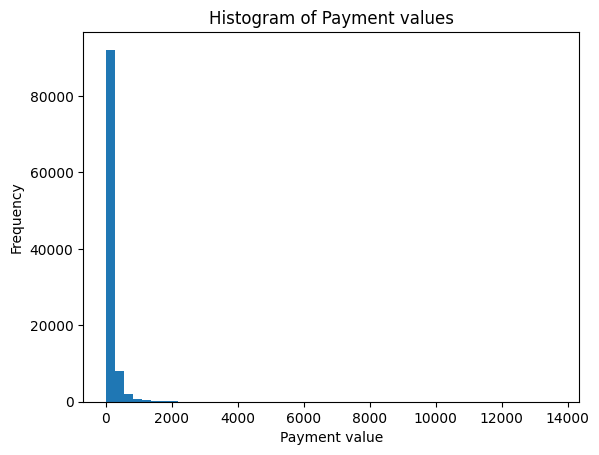

In [38]:
plt.hist(df_payments["payment_value"], bins=50)
plt.xlabel("Payment value")
plt.ylabel("Frequency")
plt.title("Histogram of Payment values")
plt.show()

## 5.df_reviews

In [39]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


It is reasonable that we have review_score for all reviews (they have to be created somehow) but not all reviews have comments. Also, we see that the number of reviews is lower than the number of unique orders (from other dataframes).

This dataframe while interesting from a marketing standpoint will probably not contribute much to our analysis

In [40]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


**We may however see if the reviews were made before the delivery of the order. In this case it could be said that they could somehow influence the delay of the order. This is probably unlikely but we could say that upon a bad review**

 We cannot, of course, anaylyse reviews completed after the delivery as this would introduce obvious data leakage

 Let's look at both data through a merge

In [41]:
df_review_delivery = (
    df_reviews.merge(
        df_orders[["order_id", "order_delivered_customer_date"]],
        on="order_id",
        how="inner"   # use "left" if you want to keep all reviews even if some orders are missing
    )
)

df_review_delivery.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_delivered_customer_date
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2018-01-17 18:42:41
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,2018-03-09 23:17:20
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,2018-02-16 17:28:48
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,2017-04-20 09:08:35
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,2018-02-28 16:33:35


In [42]:
# Convert to datetime
df_review_delivery["review_answer_timestamp"] = pd.to_datetime(df_review_delivery["review_answer_timestamp"])
df_review_delivery["order_delivered_customer_date"] = pd.to_datetime(df_review_delivery["order_delivered_customer_date"])

# New column: review date - delivery date
df_review_delivery["review_minus_delivery"] = (
    df_review_delivery["review_answer_timestamp"] - df_review_delivery["order_delivered_customer_date"]
)

df_review_delivery["review_minus_delivery_days"] = df_review_delivery["review_minus_delivery"].dt.days

(df_review_delivery["review_minus_delivery_days"] < 0).sum()

np.int64(4795)

We have some 4795 negative values which means some reviews were made before the order was delivered

In [43]:
df_review_delivery.loc[df_review_delivery["review_minus_delivery_days"] < 0,
                       ["order_id", "order_delivered_customer_date", "review_creation_date", "review_answer_timestamp", "review_minus_delivery_days"]]


,order_id,order_delivered_customer_date,review_creation_date,review_answer_timestamp,review_minus_delivery_days
16,0dacf04c5ad59fd5a0cc1faa07c34e39,2018-02-21 01:25:41,2018-01-18 00:00:00,2018-01-20 21:25:45,-32.0
32,68e55ca79d04a79f20d4bfc0146f4b66,2018-04-11 02:12:46,2018-04-08 00:00:00,2018-04-09 12:22:39,-2.0
39,3c314f50bc654f3c4e317b055681dff9,2017-04-24 09:18:11,2017-04-21 00:00:00,2017-04-23 05:37:03,-2.0
41,88096595631e8d26b658306256e3ce34,2018-02-19 22:54:48,2018-02-08 00:00:00,2018-02-10 04:28:43,-10.0
47,b3271f5ebce80cbecb67c5b88487a44a,2017-05-15 11:22:26,2017-05-13 00:00:00,2017-05-14 02:57:19,-2.0
...,...,...,...,...,...
99091,837b75362f8a7c08c85182dfd16cb72d,2018-08-15 01:38:58,2018-08-12 00:00:00,2018-08-12 13:51:31,-3.0
99094,e78cde66f03731202b0f5e082b0b0cff,2018-04-04 14:22:02,2018-03-29 00:00:00,2018-03-29 22:21:55,-6.0
99098,cdbe57b33f10dd54db2421744ab4a045,2017-09-09 01:38:29,2017-09-01 00:00:00,2017-09-01 18:27:53,-8.0
99114,d2cc32c3614a3446aef94cfc1ade79b3,2018-03-24 18:51:08,2018-03-14 00:00:00,2018-03-17 14:17:27,-8.0


This is very odd and would greatly restrict the sample. It may be that the review is not only about the product but also about the ordering experience. This variable may be difficult to include into our analysis.

In [44]:
neg = df_review_delivery[df_review_delivery["review_minus_delivery_days"] < 0]

neg["order_id"].nunique(), len(neg), len(neg) -neg["order_id"].nunique()

(4769, 4795, 26)

We have more than one review for a given order (26 duplicates shown below)

In [45]:
neg_dup = neg[neg.duplicated("order_id", keep=False)].sort_values("order_id")
neg_dup["order_id"].value_counts().head(30)

order_id
02355020fd0a40a0d56df9f6ff060413    2
0749426d1c48fe5943cbdf1316ace0aa    2
09a38776c4e31230864f867821174daa    2
0d6cc2219ef268358eac3c49b47abca9    2
1c308eca3f339414a92e518e2a2e5ee9    2
338d2237cff9d84c960705a68b88c638    2
33f1e992ba3e439bfd0d432164a3d44a    2
38e31ec9d0ed250702ede5bb610d963b    2
4863e15fa53273cc7219c58f5ffda4fb    2
559d606ac642899e44550f194fec7e08    2
5642f00882c2ab59e001778dc483135f    2
5c2049caca936695cfa43805ebe7d8e3    2
5e4c365dd3cf7769a88981f408d069d3    2
6401cfe160d72392195bd6e311a582cd    2
6b99ff92735c747557e84a5f5cd7a560    2
70c77e51e0f179d75a64a614135afb6a    2
71717b68820ab37f844d6799422804d7    2
7b994fc7c7528d2098eebcb19d18ce7e    2
871ea4c791e2d977d094700806eef385    2
94f522c26f2681ad053b999e34e7b317    2
ab71e5dff0ed652f1559e1860391bd22    2
acbaf2e843c77c9749c79030163c8b81    2
afed4265a8b956d840bc032e54dfccd1    2
bee4fbc438d2d48527e812cb6a1c8166    2
bf9a3a8d9db6be5e4dfcfe2f071ef405    2
d22f0b06e1519065d7eddb2ba6b79b63    2
Nam

In [46]:
df_reviews["order_id"].duplicated().sum(), df_orders["order_id"].duplicated().sum()

(np.int64(551), np.int64(0))

The duplication is coming from our review dataframe (check)

> **Unfortunately, there is nothing we can use in this dataframe as taking review scores would introduce data leakage into the model**

## 6.df_orders

In [47]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


We can immediately spot an important issue - we seem to be losing orders as we go through the delivery process.

In [48]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


We should also probably only look at *delivered* orders.

In [49]:
df_orders['order_status'].describe()

count         99441
unique            8
top       delivered
freq          96478
Name: order_status, dtype: object

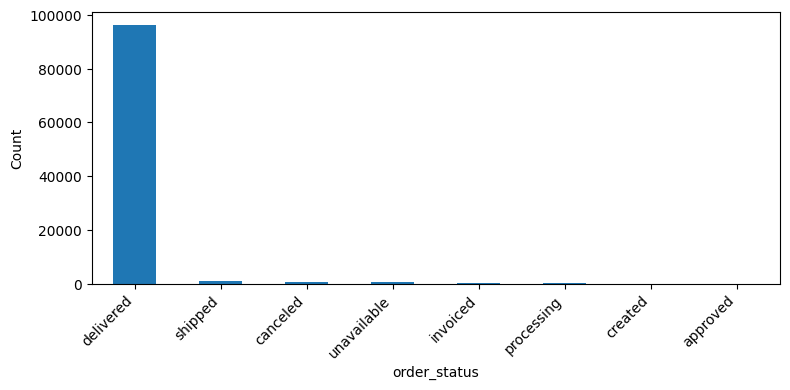

In [50]:
plt.figure(figsize=(8,4))
df_orders["order_status"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xlabel("order_status")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The vast majority of our orders were delivered which is good as this will not decrease our sample in a significant way

Constructing our target variable - delay in order (in days). Estimated delivery time is given in days so would be unable to go any deeper when it comes to date granularity.

In [51]:
df_orders_status_delivered = df_orders[df_orders["order_status"] == "delivered"].copy()
df_orders_status_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96478 non-null  object
 1   customer_id                    96478 non-null  object
 2   order_status                   96478 non-null  object
 3   order_purchase_timestamp       96478 non-null  object
 4   order_approved_at              96464 non-null  object
 5   order_delivered_carrier_date   96476 non-null  object
 6   order_delivered_customer_date  96470 non-null  object
 7   order_estimated_delivery_date  96478 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


In [52]:
df_orders_status_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


We still lose some orders along the way. Let's add another condition

In [53]:
df_orders_status_delivered = df_orders[
    (df_orders["order_status"] == "delivered") &
    (df_orders["order_delivered_customer_date"].notna())
].copy()

df_orders_status_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96470 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96470 non-null  object
 1   customer_id                    96470 non-null  object
 2   order_status                   96470 non-null  object
 3   order_purchase_timestamp       96470 non-null  object
 4   order_approved_at              96456 non-null  object
 5   order_delivered_carrier_date   96469 non-null  object
 6   order_delivered_customer_date  96470 non-null  object
 7   order_estimated_delivery_date  96470 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


In [54]:
df_orders_status_delivered['order_delivered_customer_date'] = pd.to_datetime(df_orders_status_delivered['order_delivered_customer_date'])
df_orders_status_delivered['order_estimated_delivery_date'] = pd.to_datetime(df_orders_status_delivered['order_estimated_delivery_date'])

# Delay (in days) = actual date - estimated date (positive indicates a delay, negative indicates an earlier delivery)
df_orders_status_delivered["delay_days"] = (
    df_orders_status_delivered['order_delivered_customer_date']- df_orders_status_delivered['order_estimated_delivery_date']
).dt.days

In [55]:
df_orders_status_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96470 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96470 non-null  object        
 1   customer_id                    96470 non-null  object        
 2   order_status                   96470 non-null  object        
 3   order_purchase_timestamp       96470 non-null  object        
 4   order_approved_at              96456 non-null  object        
 5   order_delivered_carrier_date   96469 non-null  object        
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96470 non-null  datetime64[ns]
 8   delay_days                     96470 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 7.4+ MB


In [56]:
df_orders_status_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10


In [57]:
df_orders_status_delivered.nunique()

order_id                         96470
customer_id                      96470
order_status                         1
order_purchase_timestamp         95948
order_approved_at                88267
order_delivered_carrier_date     80106
order_delivered_customer_date    95658
order_estimated_delivery_date      445
delay_days                         198
dtype: int64

count    96470.000000
mean       -11.875889
std         10.182105
min       -147.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
max        188.000000
Name: delay_days, dtype: float64
0.800    -6.0
0.850    -4.0
0.900    -2.0
0.950     3.0
0.990    18.0
0.995    27.0
Name: delay_days, dtype: float64
Skewness:  2.0161633367884493
Kurtosis:  28.070322387773093


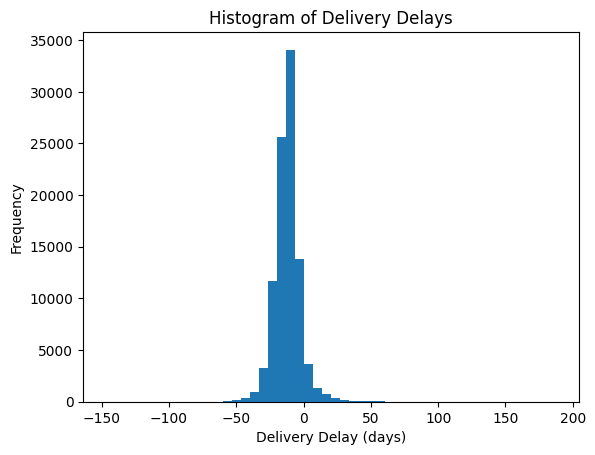

In [58]:
print(df_orders_status_delivered["delay_days"].describe())
print(df_orders_status_delivered["delay_days"].quantile([0.8, 0.85, 0.9, 0.95, 0.99, 0.995]))
print("Skewness: ",df_orders_status_delivered["delay_days"].skew())
print("Kurtosis: ",df_orders_status_delivered["delay_days"].kurtosis())

plt.hist(df_orders_status_delivered["delay_days"], bins=50)
plt.xlabel("Delivery Delay (days)")
plt.ylabel("Frequency")
plt.title("Histogram of Delivery Delays")
plt.show()

The **skewness** is minimally positive which is definitely confirmed by the histogram. As expected, **kurtosis** is extremely high. We see that the vast majority of the data is centered around small (in absolute terms) negative value.

In [59]:
print("The number of orders for which the delay was zero: ", (df_orders_status_delivered["delay_days"] == 0).sum())
print(f"As a percentage of the total delivered orders: {(df_orders_status_delivered["delay_days"] == 0).sum()/ len(df_orders_status_delivered):.2%}")

print("\nThe number of orders for which the delay greater than zero: ", (df_orders_status_delivered["delay_days"] > 0).sum())
print(f"As a percentage of the total delivered orders: {(df_orders_status_delivered["delay_days"] > 0).sum()/ len(df_orders_status_delivered):.2%}")

print("\nThe number of orders for which the delay less than zero: ", (df_orders_status_delivered["delay_days"] < 0).sum())
print(f"As a percentage of the total delivered orders: {(df_orders_status_delivered["delay_days"] < 0).sum()/ len(df_orders_status_delivered):.2%}")

print(f"\nCheck (percentages summing to 100%): {(df_orders_status_delivered["delay_days"] == 0).sum()/ len(df_orders_status_delivered)+ \
                (df_orders_status_delivered["delay_days"] > 0).sum()/ len(df_orders_status_delivered)+ \
                 (df_orders_status_delivered["delay_days"] < 0).sum()/ len(df_orders_status_delivered)     :.2%}")


The number of orders for which the delay was zero:  1292
As a percentage of the total delivered orders: 1.34%

The number of orders for which the delay greater than zero:  6534
As a percentage of the total delivered orders: 6.77%

The number of orders for which the delay less than zero:  88644
As a percentage of the total delivered orders: 91.89%

Check (percentages summing to 100%): 100.00%


> **We see quite a suprising pattern. Most orders are delivered well before the estimated delivery date**

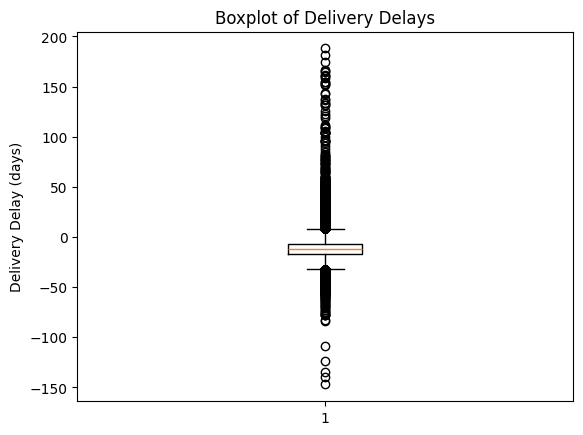

In [60]:
plt.boxplot(df_orders_status_delivered["delay_days"])
plt.ylabel("Delivery Delay (days)")
plt.title("Boxplot of Delivery Delays")
plt.show()

**We may also want to fit a dsitribution to our delay data in order to get a better understanding of its properties. We have huge tails and some leptokurtosis.**

As we are using the data to fit a distribution and then we take these **fitted parameters for our null hypothesis, the critical values in the KS test are invalid** (too optimistic) as per [H. W. Lilliefors (1967)](https://web.physics.utah.edu/~belz/phys4730/lab18/1967_lilliefors_jasa.pdf?utm_source). The test statistic distribution is determined by Monte Carlo simulations. We consider a boostrap-modified KS test below.

Fitted Normal: mu=-11.8759, sigma=10.1821
KS statistic: D=0.1088
Bootstrap KS p-value: p=0.000999 -> Reject Normal (alpha=0.05)


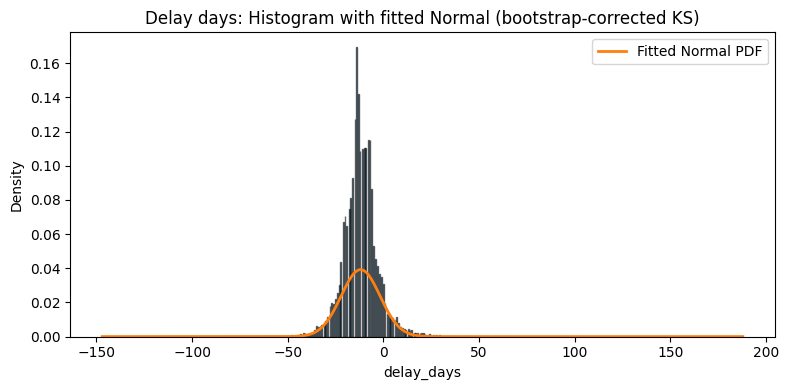

In [61]:
# KS test with a plot

# ---- 1) data ----
x = df_orders_status_delivered["delay_days"].dropna().astype(float).to_numpy() # corrections probably unnecessary 
n = len(x)

# ---- 2) fit Normal (MLE) ----
mu_hat, sigma_hat = stats.norm.fit(x)

# ---- 3) observed KS statistic (against fitted Normal) ----
D_obs = stats.kstest(x, "norm", args=(mu_hat, sigma_hat)).statistic

# ---- 4) parametric bootstrap p-value (Lilliefors-style correction) ----
B = 1000   # increase to 5000 if you want more precision
rng = np.random.default_rng(0)

Ds = np.empty(B)
for b in range(B):
    # simulate from fitted normal
    xb = rng.normal(loc=mu_hat, scale=sigma_hat, size=n)

    # refit parameters on bootstrap sample
    mu_b, sigma_b = stats.norm.fit(xb)

    # KS statistic for bootstrap sample vs its own fitted normal
    Ds[b] = stats.kstest(xb, "norm", args=(mu_b, sigma_b)).statistic

# bootstrap p-value: how often simulated D >= observed D
p_boot = (np.sum(Ds >= D_obs) + 1) / (B + 1)

# Decision
alpha = 0.05
decision = "Fail to reject Normal" if p_boot >= alpha else "Reject Normal"

# Print results
print(f"Fitted Normal: mu={mu_hat:.4f}, sigma={sigma_hat:.4f}")
print(f"KS statistic: D={D_obs:.4f}")
print(f"Bootstrap KS p-value: p={p_boot:.6f} -> {decision} (alpha={alpha})")

# Plot histogram + fitted Normal PDF 
plt.figure(figsize=(8, 4))
plt.hist(x, bins="fd", density=True, alpha=0.6, edgecolor="black")

xs = np.linspace(x.min(), x.max(), 500)
plt.plot(xs, stats.norm.pdf(xs, mu_hat, sigma_hat), linewidth=2, label="Fitted Normal PDF")

plt.xlabel("delay_days")
plt.ylabel("Density")
plt.title("Delay days: Histogram with fitted Normal (bootstrap-corrected KS)")
plt.legend()
plt.tight_layout()
plt.show()


The p-value is basically 0 and it's clear that we are not dealing with the normal distribution.

**Now, let's test the t-Student distribution** 

An analogous procedure but for a t-Student distribution is too taxing computationally so me introduce some modifications. We reduce the boostrap iterations to 200, and implement subsampling from our data for the test (5000).

Subsample size n=5000, bootstrap B=200
Fitted t: df=3.5129, loc=-12.6841, scale=6.5397
KS statistic: D=0.0605
Bootstrap KS p-value: p=0.527363 -> Fail to reject t-fit


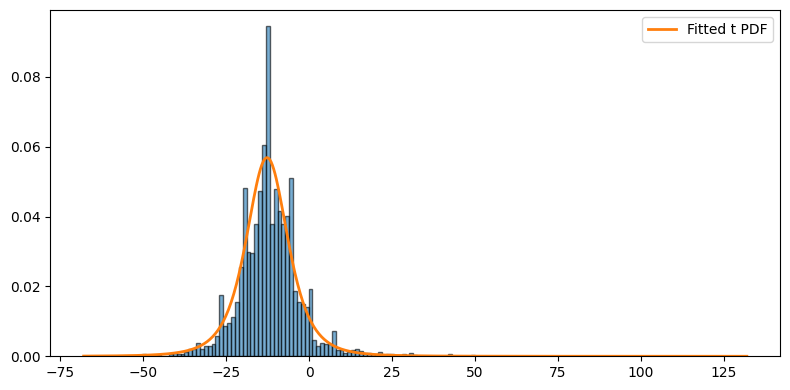

In [62]:
x = df_orders_status_delivered["delay_days"].dropna().astype(float).to_numpy()

rng = np.random.default_rng(0)
m = min(5000, len(x))          # subsample size
x = rng.choice(x, size=m, replace=False)
n = len(x)

df_hat, loc_hat, scale_hat = stats.t.fit(x)
D_obs = stats.kstest(x, "t", args=(df_hat, loc_hat, scale_hat)).statistic

B = 200
Ds = np.empty(B)
for b in range(B):
    xb = stats.t.rvs(df_hat, loc=loc_hat, scale=scale_hat, size=n, random_state=rng)
    df_b, loc_b, scale_b = stats.t.fit(xb)
    Ds[b] = stats.kstest(xb, "t", args=(df_b, loc_b, scale_b)).statistic

p_boot = (np.sum(Ds >= D_obs) + 1) / (B + 1)

alpha = 0.05
decision = "Fail to reject t-fit" if p_boot >= alpha else "Reject t-fit"

print(f"Subsample size n={n}, bootstrap B={B}")
print(f"Fitted t: df={df_hat:.4f}, loc={loc_hat:.4f}, scale={scale_hat:.4f}")
print(f"KS statistic: D={D_obs:.4f}")
print(f"Bootstrap KS p-value: p={p_boot:.6f} -> {decision}")

plt.figure(figsize=(8, 4))
plt.hist(x, bins="fd", density=True, alpha=0.6, edgecolor="black")
xs = np.linspace(x.min(), x.max(), 500)
plt.plot(xs, stats.t.pdf(xs, df_hat, loc=loc_hat, scale=scale_hat), linewidth=2, label="Fitted t PDF")
plt.legend()
plt.tight_layout()
plt.show()

Here, we see that we cannot reject the null so our data does come from a t-Student distribution. This should be considered with great caution as it's clear from the plot that our fitted distribution does not account perfectly for high leptokurtic bumps. Unfortunatelty, t-Student distribution does not come from the Exponential Dispersion Family so it's uses for our analysis are limited.

## 7.df_products

In [63]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [64]:
df_products.nunique()

product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

In [65]:
df_products.head(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


Here we can product id, category name (translation in the last dataframe), product name length and description (number of characters), quantity of photos given on the site for the product, weight of the product (in grams), product length, height and width (in cm).

We also have some null values in the first few columns. Let's take a look at them:

In [66]:
print("\nNumber of rows with nulls: ", len(df_products[df_products.isna().any(axis=1)]))
df_products[df_products.isna().any(axis=1)].head(10)


Number of rows with nulls:  611


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
244,e10758160da97891c2fdcbc35f0f031d,NaN,NaN,NaN,NaN,2200.0,16.0,2.0,11.0
294,39e3b9b12cd0bf8ee681bbc1c130feb5,NaN,NaN,NaN,NaN,300.0,16.0,7.0,11.0
299,794de06c32a626a5692ff50e4985d36f,NaN,NaN,NaN,NaN,300.0,18.0,8.0,14.0
347,7af3e2da474486a3519b0cba9dea8ad9,NaN,NaN,NaN,NaN,200.0,22.0,14.0,14.0
428,629beb8e7317703dcc5f35b5463fd20e,NaN,NaN,NaN,NaN,1400.0,25.0,25.0,25.0


This is not a huge number but also we have nulls in the less interesting features (product_category_name, product_name_lenght,	product_description_lenght,	product_photos_qty). For now we will create a new dataframe without nulls:

In [67]:
df_products_nonull = df_products.dropna()
df_products_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


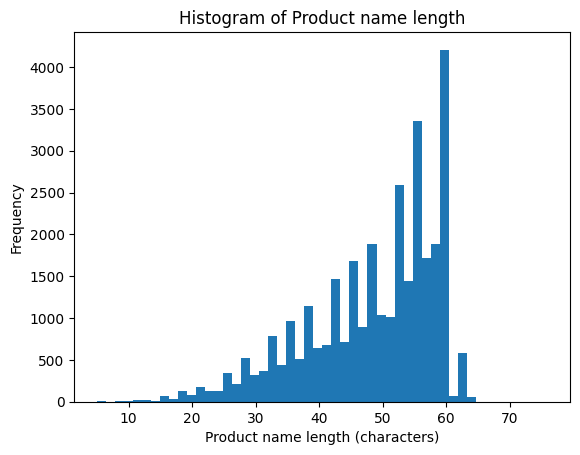

In [68]:
plt.hist(df_products["product_name_lenght"], bins=50)
plt.xlabel("Product name length (characters)")
plt.ylabel("Frequency")
plt.title("Histogram of Product name length")
plt.show()

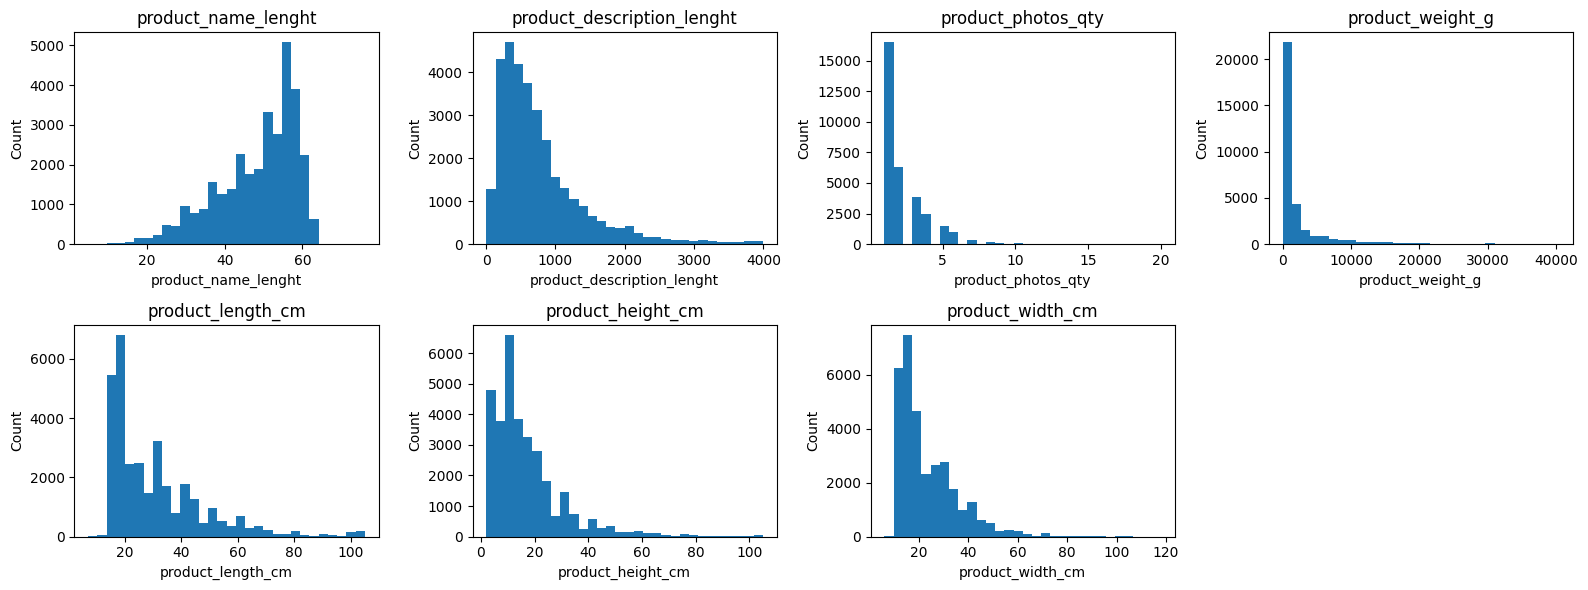

In [69]:

cols = [
    "product_name_lenght",
    "product_description_lenght",
    "product_photos_qty",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
]

# ---- grid size (auto) ----
n = len(cols)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows))
axes = axes.ravel()

for i, col in enumerate(cols):
    x = df_products_nonull[col].dropna()
    axes[i].hist(x, bins=30)
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# hide any unused subplots (since 7 doesn’t fill a 2x4 grid)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

We see that most product name lengths are long, while all the majority of values for the other variables accumulate in the lower range

## 8.df_sellers

In [70]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [71]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [72]:
df_sellers.nunique()

seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

In [73]:
df_sellers["seller_state"].describe()

count     3095
unique      23
top         SP
freq      1849
Name: seller_state, dtype: object

This is a small dataframe we may use for mapping with other seller id's. We will most likely just use the **seller_state** variable as a categorical variable since the location of the seller may very well have an effect on order delays. We can run some preliminary analysis and plot histograms of delays filtered by seller state.

Given the data schema (refer to [Data - introduction](#Data-and-introduction)) we need to do some merging in order to map appropriate data. Our dataframe *df_sellers* has **seller_id** and **seller_state**, *df_order_items* has **seller_id** and **order_id**, and *df_orders_status_delivered* has **order_id** and **delay_days**. 

There also arrises the issue of orders with different items per order - they have different sellers. As such we need to adopt acertain simplification. We will calculate which seller contributes the most to the total order price, and we will use this seller as the one seller per order

In [74]:
# --- 1) seller_state lookup ---
seller_state = (
    df_sellers[["seller_id", "seller_state"]]
    .drop_duplicates("seller_id")
)

# --- 2) delay per order ---
order_delay = (
    df_orders_status_delivered[["order_id", "delay_days"]]
    .drop_duplicates("order_id")
)

# --- 3) compute "main seller" per order from order_items ---
# total_value = price + freight_value (you can change this to just "price" if you prefer)
oi = df_order_items[["order_id", "seller_id", "price", "freight_value"]].copy()
oi["item_value"] = oi["price"].fillna(0) + oi["freight_value"].fillna(0)

seller_totals = (
    oi.groupby(["order_id", "seller_id"], as_index=False)["item_value"]
      .sum()
)

# pick the seller with the max total per order
idx = seller_totals.groupby("order_id")["item_value"].idxmax()
main_seller = seller_totals.loc[idx, ["order_id", "seller_id"]]

# --- 4) merge to get seller_state + delay_days ---
df_one_row_per_order_SellerState = (
    main_seller
    .merge(seller_state, on="seller_id", how="left")
    .merge(order_delay, on="order_id", how="inner")
    [["order_id", "seller_id", "seller_state", "delay_days"]]
)

df_one_row_per_order_SellerState.info()
df_one_row_per_order_SellerState.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96470 entries, 0 to 96469
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_id      96470 non-null  object
 1   seller_id     96470 non-null  object
 2   seller_state  96470 non-null  object
 3   delay_days    96470 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


,order_id,seller_id,seller_state,delay_days
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,SP,-9
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,SP,-3
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,MG,-14
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,SP,-6
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,PR,-16
5,00048cc3ae777c65dbb7d2a0634bc1ea,6426d21aca402a131fc0a5d0960a3c90,SP,-15
6,00054e8431b9d7675808bcb819fb4a32,7040e82f899a04d1b434b795a43b4617,SP,-17
7,000576fe39319847cbb9d288c5617fa6,5996cddab893a4652a15592fb58ab8db,SP,-16
8,0005a1a1728c9d785b8e2b08b904576c,a416b6a846a11724393025641d4edd5e,SP,0
9,0005f50442cb953dcd1d21e1fb923495,ba143b05f0110f0dc71ad71b4466ce92,SP,-19


In [75]:
df_one_row_per_order_SellerState.nunique()

order_id        96470
seller_id        2957
seller_state       22
delay_days        198
dtype: int64

Through the merging and simplification we managed to keep 22 states. Let's see if the delays have different distributions based on the seller state through simple hitogram visualisations.

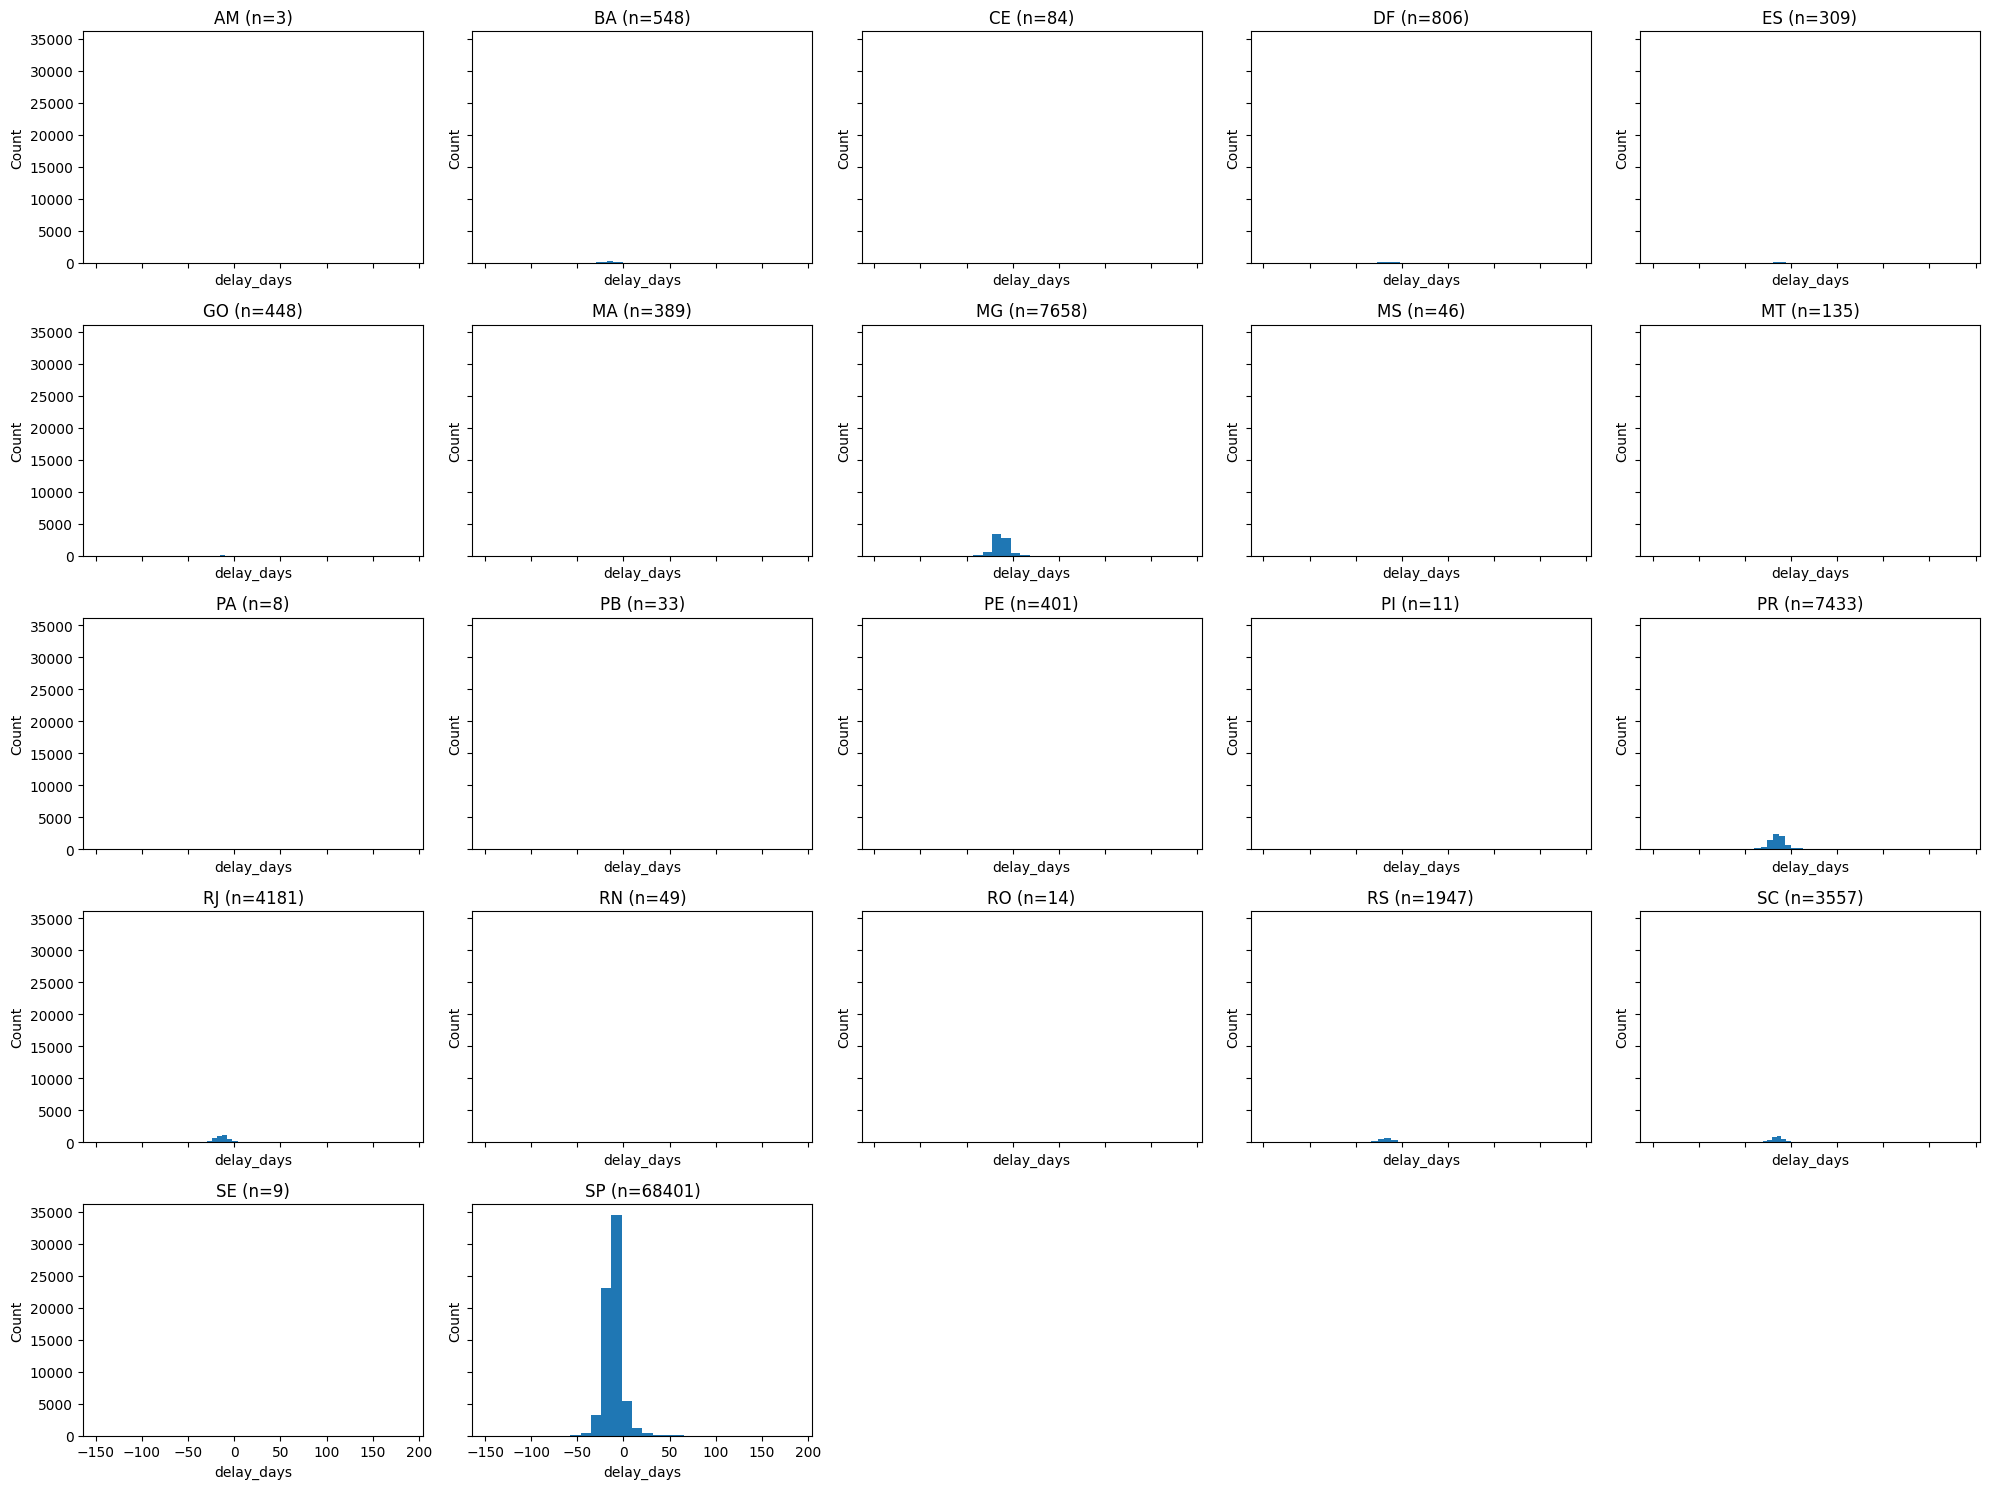

In [76]:
# Auxiliary df for histograms
df_plot = df_one_row_per_order_SellerState[["seller_state", "delay_days"]].dropna()

states = sorted(df_plot["seller_state"].unique())
n = len(states)

# --- grid layout ---
ncols = 5                          # change to 4/6 if you prefer
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True) # shared axes
axes = axes.ravel()

# (optional) global bins so all subplots are comparable
bins = 30  # or: bins = range(int(df_plot.delay_days.min()), int(df_plot.delay_days.max()) + 2)

for i, st in enumerate(states):
    x = df_plot.loc[df_plot["seller_state"] == st, "delay_days"]
    axes[i].hist(x, bins=bins)
    axes[i].set_title(f"{st} (n={len(x)})")
    axes[i].set_xlabel("delay_days")
    axes[i].set_ylabel("Count")

# turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


This is a stunning result. This means that we have more than 66% of our observations from one state. This will be important for final variable selection - we should collapse the levels of seller_state to only a few values as opposed to 22.

## 9.df_prod_translate

From an analytical perspective this dataframe doesn't provide much but for convenience it may be better to have English category names in our usable dataset

In [77]:
df_prod_translate.info()
print("\nNumber of unique entries: ", df_prod_translate.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB

Number of unique entries:  product_category_name            71
product_category_name_english    71
dtype: int64


In [78]:
df_prod_translate.head(10)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


We will use this data set simply as a translation of product categories. Let's merge it with *df_products_nonull* as this particular dataframe won't be useful on its own.

In [79]:
df_products_nonull.nunique()

product_id                    32340
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2202
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

We seem to have more category name here than in our translation dataframe. Let's look at a quick comparison check to see which values we are missing (we will need to create two translations)

In [80]:
# --- 1) pull the unique category lists (and clean) ---
cat_t = (
    df_prod_translate["product_category_name"]
    .dropna()
    .astype(str)
    .str.strip()
)

cat_p = (
    df_products_nonull["product_category_name"]
    .dropna()
    .astype(str)
    .str.strip()
)

set_t = set(cat_t.unique())
set_p = set(cat_p.unique())

# Print
print("Unique in translation:", len(set_t))
print("Unique in products:", len(set_p))
print("Overlap:", len(set_t & set_p))
print("Only in translation (missing in products):", len(set_t - set_p))
print("Only in products (missing in translation):", len(set_p - set_t))

# --- 2) a full comparison table of ALL values at once ---
all_cats = sorted(set_t | set_p)

comparison = pd.DataFrame({"product_category_name": all_cats})
comparison["in_translation_df"] = comparison["product_category_name"].isin(set_t)
comparison["in_products_df"]     = comparison["product_category_name"].isin(set_p)

# attach english translation where available
comparison = comparison.merge(
    df_prod_translate[["product_category_name", "product_category_name_english"]]
      .drop_duplicates("product_category_name"),
    on="product_category_name",
    how="left"
)

# helpful "status" label
comparison["status"] = pd.Series(pd.NA, index=comparison.index)
comparison.loc[comparison["in_translation_df"] & comparison["in_products_df"], "status"] = "MATCH"
comparison.loc[comparison["in_translation_df"] & ~comparison["in_products_df"], "status"] = "ONLY_IN_TRANSLATION"
comparison.loc[~comparison["in_translation_df"] & comparison["in_products_df"], "status"] = "ONLY_IN_PRODUCTS"

# sort so mismatches go to the bottom
comparison = comparison.sort_values(
    by=["status", "product_category_name"],
    ascending=[True, True]
).reset_index(drop=True)

comparison


Unique in translation: 71
Unique in products: 73
Overlap: 71
Only in translation (missing in products): 0
Only in products (missing in translation): 2


,product_category_name,in_translation_df,in_products_df,product_category_name_english,status
0,agro_industria_e_comercio,True,True,agro_industry_and_commerce,MATCH
1,alimentos,True,True,food,MATCH
2,alimentos_bebidas,True,True,food_drink,MATCH
3,artes,True,True,art,MATCH
4,artes_e_artesanato,True,True,arts_and_craftmanship,MATCH
...,...,...,...,...,...
68,telefonia,True,True,telephony,MATCH
69,telefonia_fixa,True,True,fixed_telephony,MATCH
70,utilidades_domesticas,True,True,housewares,MATCH
71,pc_gamer,False,True,NaN,ONLY_IN_PRODUCTS


We can see the two categories we need to translate:
* pc_gamer - we can simply leave it as it is so "pc_gamer"
* portateis_cozinha_e_preparadores_de_alimentos - we will translate it as "portable_kitchen_food_prep"

Now, we can add it to our dataframe *df_prod_translate*

In [81]:
# 1) the missing mappings
new_translations = pd.DataFrame({
    "product_category_name": [
        "pc_gamer",
        "portateis_cozinha_e_preparadores_de_alimentos"
    ],
    "product_category_name_english": [
        "pc_gamer",
        "portable_kitchen_food_prep"
    ]
})

# 2) add them to the translation df
df_prod_translate = pd.concat([df_prod_translate, new_translations], ignore_index=True)

# 3) keep one row per category (keeps the LAST occurrence, i.e., new ones if they were duplicates)
df_prod_translate = df_prod_translate.drop_duplicates(
    subset="product_category_name",
    keep="last"
).reset_index(drop=True)

# Quick visual check to see if the values were added appropriately
df_prod_translate[df_prod_translate["product_category_name"].isin(new_translations["product_category_name"])]


,product_category_name,product_category_name_english
71,pc_gamer,pc_gamer
72,portateis_cozinha_e_preparadores_de_alimentos,portable_kitchen_food_prep


In [82]:
df_prod_translate.info()
df_prod_translate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          73 non-null     object
 1   product_category_name_english  73 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,seguros_e_servicos,security_and_services
71,pc_gamer,pc_gamer


In [83]:
df_prod_translate.nunique()

product_category_name            73
product_category_name_english    73
dtype: int64

Looks ok, we may now merge

In [84]:
df_products_nonull

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [85]:
# add english translation to products
df_products_nonull = df_products_nonull.merge(
    df_prod_translate[["product_category_name", "product_category_name_english"]],
    on="product_category_name",
    how="left"
)

# quick sanity checks
print("Rows in df_products_nonull:", len(df_products_nonull))
print("Missing english translations:", df_products_nonull["product_category_name_english"].isna().sum())

# (optional) inspect any misses
df_products_nonull.loc[df_products_nonull["product_category_name_english"].isna(),
                       ["product_category_name"]].drop_duplicates()

df_products_nonull

Rows in df_products_nonull: 32340
Missing english translations: 0


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32335,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32336,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32337,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32338,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [86]:
df_products_nonull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32340 entries, 0 to 32339
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32340 non-null  object 
 1   product_category_name          32340 non-null  object 
 2   product_name_lenght            32340 non-null  float64
 3   product_description_lenght     32340 non-null  float64
 4   product_photos_qty             32340 non-null  float64
 5   product_weight_g               32340 non-null  float64
 6   product_length_cm              32340 non-null  float64
 7   product_height_cm              32340 non-null  float64
 8   product_width_cm               32340 non-null  float64
 9   product_category_name_english  32340 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.5+ MB


In [87]:
df_products_nonull.nunique()

product_id                       32340
product_category_name               73
product_name_lenght                 66
product_description_lenght        2960
product_photos_qty                  19
product_weight_g                  2202
product_length_cm                   99
product_height_cm                  102
product_width_cm                    95
product_category_name_english       73
dtype: int64

It seems like our merging was successful. We may drop the Portuguese category names but we'll keep them for now, and drop them later when we have our full feature set

In [88]:
# If we want only English going forward
# df_products_nonull = df_products_nonull.drop(columns=["product_category_name"])

# Feature engineering

Now, that we've made an initial inspection of our dataframes, we need to construct usable features. We have a lot of data but it requires some pre-processing so that our statistical models can take advantage of them

## Orders with mult sellers/products

> **Refer to Merging duplicate rows in df_order_items** for the start of the discussion



We construct an auxiliary dataframe to check if an order_id has multiple sellers or product types (has_multi_product_or_seller)

In [89]:
# ---- 0) pick the orders+delay source (adjust name if needed) ----
orders_delay = df_orders_status_delivered[["order_id", "delay_days"]].drop_duplicates("order_id")

# ---- 1) compute within-order variability in df_order_items ----
g = df_order_items.groupby("order_id")

order_item_stats = pd.DataFrame({
    "n_item_rows": g.size(), # If this equals 1 → order appears once in items. If >1 → duplicated order_id in items (multiple item rows).
    "n_distinct_products": g["product_id"].nunique(), # If equals 1 → all item rows refer to the same product.
                                                      # If >1 → order contains multiple products.
    "n_distinct_sellers": g["seller_id"].nunique(),  # If equals 1 → all item rows refer to the same seller.
                                                      # If >1 → order contains multiple sellers.
}).reset_index() # After grouping, order_id is stored as the index. Reset_index() moves it back into a normal column so we can merge later.

# Checking for true duplicates
order_item_stats["has_duplicate_rows_in_items"] = order_item_stats["n_item_rows"].gt(1) # means “greater than 1”
                                                                                        # True if the order has more than 1 row in df_order_items
                                                                                        # False otherwise

# Main check
# Flag : more than 1 product OR more than 1 seller within the order
order_item_stats["has_multi_product_or_seller"] = (
    order_item_stats["n_distinct_products"].gt(1) | order_item_stats["n_distinct_sellers"].gt(1))

# ---- 2) auxiliary dataframe: all orders (from orders_delay), with the binary identifier ----
aux = orders_delay.merge(order_item_stats, on="order_id", how="left")

# Orders that exist in orders_delay but not in df_order_items (should be rare) -> treat as normal
aux[["n_item_rows","n_distinct_products","n_distinct_sellers"]] = aux[["n_item_rows","n_distinct_products","n_distinct_sellers"]].fillna(0).astype(int)
aux[["has_duplicate_rows_in_items","has_multi_product_or_seller"]] = aux[["has_duplicate_rows_in_items","has_multi_product_or_seller"]].fillna(False)

aux = aux[["order_id", "has_multi_product_or_seller", "delay_days",
           "has_duplicate_rows_in_items", "n_item_rows", "n_distinct_products", "n_distinct_sellers"]]

aux.info()
aux.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96470 entries, 0 to 96469
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   order_id                     96470 non-null  object
 1   has_multi_product_or_seller  96470 non-null  bool  
 2   delay_days                   96470 non-null  int64 
 3   has_duplicate_rows_in_items  96470 non-null  bool  
 4   n_item_rows                  96470 non-null  int64 
 5   n_distinct_products          96470 non-null  int64 
 6   n_distinct_sellers           96470 non-null  int64 
dtypes: bool(2), int64(4), object(1)
memory usage: 3.9+ MB


,order_id,has_multi_product_or_seller,delay_days,has_duplicate_rows_in_items,n_item_rows,n_distinct_products,n_distinct_sellers
0,e481f51cbdc54678b7cc49136f2d6af7,False,-8,False,1,1,1
1,53cdb2fc8bc7dce0b6741e2150273451,False,-6,False,1,1,1
2,47770eb9100c2d0c44946d9cf07ec65d,False,-18,False,1,1,1
3,949d5b44dbf5de918fe9c16f97b45f8a,False,-13,False,1,1,1
4,ad21c59c0840e6cb83a9ceb5573f8159,False,-10,False,1,1,1


In [90]:
aux["has_duplicate_rows_in_items"].describe(), (aux["has_duplicate_rows_in_items"] == True).value_counts() # this may be problematic, we will take it into account

(count     96470
 unique        2
 top       False
 freq      86835
 Name: has_duplicate_rows_in_items, dtype: object,
 has_duplicate_rows_in_items
 False    86835
 True      9635
 Name: count, dtype: int64)

In [91]:
aux.nunique()

order_id                       96470
has_multi_product_or_seller        2
delay_days                       198
has_duplicate_rows_in_items        2
n_item_rows                       17
n_distinct_products                8
n_distinct_sellers                 5
dtype: int64

In [92]:
aux["has_multi_product_or_seller"].value_counts() # magnitude of numbers is in the range we would expect

has_multi_product_or_seller
False    93273
True      3197
Name: count, dtype: int64

We got the auxiliary dataframe we wanted. We have all the order_ids and a flag to indicate if a given order_id has multiple sellers or product types. **Let's now look at the histograms of delay_days for order without multiple sellers or product types and orders with multiple sellers or product types.** The reasoning is simple. If the empirical disitibutions are similar enough (except for scale as we obviously have far more "regular" orders), then we don't sacrifice a lot of information by removing the problematic rows.

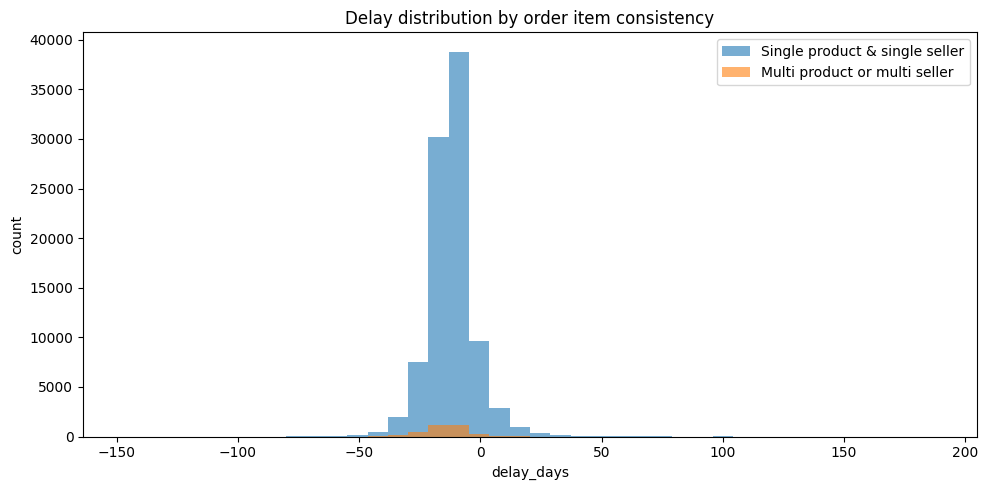

In [93]:
x0 = aux.loc[~aux["has_multi_product_or_seller"], "delay_days"].dropna().to_numpy() # safety checks, "~" FLAG is false
x1 = aux.loc[ aux["has_multi_product_or_seller"], "delay_days"].dropna().to_numpy() # safety checks, FLAG is true

# Common bins so the shapes are comparable
allx = np.concatenate([x0, x1]) if (len(x0) and len(x1)) else (x0 if len(x0) else x1)
bins = np.histogram_bin_edges(allx, bins=40)

plt.figure(figsize=(10, 5))
plt.hist(x0, bins=bins, alpha=0.6, label="Single product & single seller") # alpha for transparency of bins
plt.hist(x1, bins=bins, alpha=0.6, label="Multi product or multi seller")
plt.xlabel("delay_days")
plt.ylabel("count")
plt.title("Delay distribution by order item consistency")
plt.legend()
plt.tight_layout()
plt.show()


**This is quite a great result. The histograms are indeed similar.** The scale isn't really comparable. Let's try a histogram standardized to represent empirical densities.

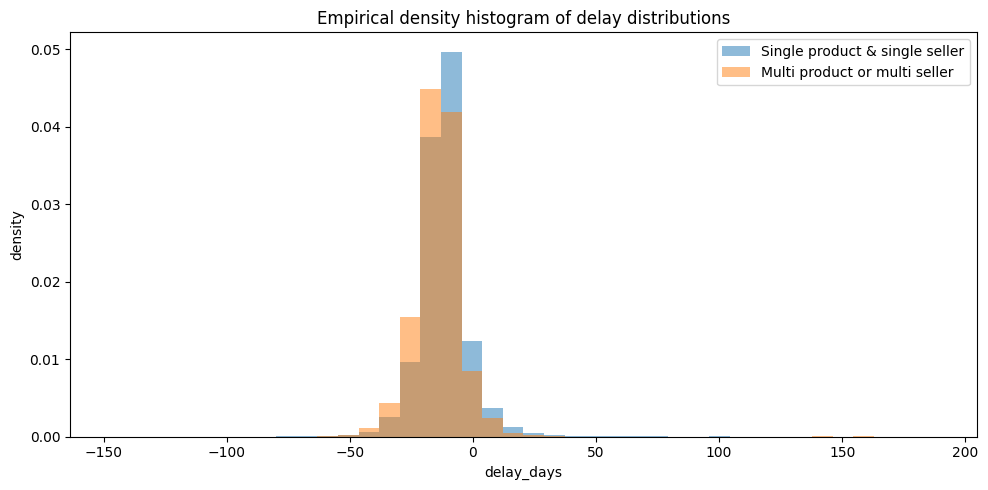

In [94]:
plt.figure(figsize=(10,5))

# Instead of bar height = count in bin
# bar height = count / (N * bin_width)
plt.hist(x0, bins=bins, density=True, alpha=0.5, label="Single product & single seller")
plt.hist(x1, bins=bins, density=True, alpha=0.5, label="Multi product or multi seller")
plt.xlabel("delay_days"); plt.ylabel("density")
plt.title("Empirical density histogram of delay distributions")
plt.legend(); plt.tight_layout(); plt.show()


We see that the orange histogram is more positively skewed. Other than that, the two are very similar.

In [95]:
aux.groupby("has_multi_product_or_seller")["delay_days"].describe()

,count,mean,std,min,25%,50%,75%,max
has_multi_product_or_seller,,,,,,,,
False,93273.0,-11.788084,10.160369,-147.0,-17.0,-12.0,-7.0,188.0
True,3197.0,-14.437598,10.479624,-61.0,-20.0,-14.0,-9.0,161.0


The counts differ for obivous reasons. The typical descriptive statistics are similar (mean, std and quartiles). We see however a differing behaviour in the tails. The "regular" orders have longer tails and some potential outliers.

In [96]:
aux.groupby("has_multi_product_or_seller")["delay_days"].quantile([0.8, 0.85, 0.9, 0.95, 0.99, 0.995])

has_multi_product_or_seller       
False                        0.800    -6.00
                             0.850    -4.00
                             0.900    -2.00
                             0.950     3.00
                             0.990    19.00
                             0.995    27.00
True                         0.800    -8.00
                             0.850    -7.00
                             0.900    -5.00
                             0.950    -1.00
                             0.990    10.04
                             0.995    19.00
Name: delay_days, dtype: float64

Similar quantiles except for the 0.9 and 0.995.

In [97]:
print("Skewness: ",aux.groupby("has_multi_product_or_seller")["delay_days"].skew())

Skewness:  has_multi_product_or_seller
False    1.957648
True     3.811830
Name: delay_days, dtype: float64


Our regular orders are less skewed which is surprising. Relatively speaking the orders with multiple sellers/product types put more weight to the left side of the distribution (visible especially on the standardized graph)

> **Decision**

**Overall, while removing rows in a non-random manner may introduce some systematic bias. However, given our tabular framework requirements (one order per row) and the fact that our target variable has very similar distributions when filtered by both types of orders, we decide to remove the order with multiple sellers/product types.**

## Creating df_orders_clean - basis for our orders

> **Now, we want to build a working basis of our unique orders.**

Removing the multiple seller/product type orders based on aux

In [98]:
bad_order_ids = aux.loc[aux["has_multi_product_or_seller"], "order_id"]
bad_order_ids = set(bad_order_ids) 

df_order_items_clean = df_order_items.loc[
    ~df_order_items["order_id"].isin(bad_order_ids)
].copy()

print("Order_items rows before:", len(df_order_items))
print("Order_items rows after :", len(df_order_items_clean))


Order_items rows before: 112650
Order_items rows after : 104974


In [99]:
check = df_order_items_clean.groupby("order_id").agg(
    n_prod=("product_id", "nunique"),
    n_sell=("seller_id", "nunique"),
)

remaining_bad = check[(check["n_prod"] > 1) | (check["n_sell"] > 1)]
print("Remaining bad orders:", len(remaining_bad))
remaining_bad.head(10)


Remaining bad orders: 39


,n_prod,n_sell
order_id,,
053245dc8f6f668c40923c3aedcd384e,2,1
08af87fbe33eeebc7840433d94718046,2,1
0c87b31e37ed8557e234cec91546d4cc,2,1
1170def5f575ee492231108cb5185570,2,1
127b06830315a6224e76085943d1f565,2,1
16547d000ee8f177f45827613e2a17f3,2,1
1a3ccc1695931b2cb7a95065e0c81e4b,2,1
2b174fe50fe22617055b7220b4b43c26,2,2
2e7a8482f6fb09756ca50c10d7bfc047,2,1


In [100]:
oid = remaining_bad.index[0]
df_order_items_clean[df_order_items_clean["order_id"] == oid].sort_values("order_item_id")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,n_distinct_sellers,n_distinct_products,total_price,total_freight,order_value_check
2283,053245dc8f6f668c40923c3aedcd384e,1,a8f6fefd2f6ad22952337438aa1bfce5,adcf50477d6a1f5d91bb9d54c4903cb5,2017-06-21 19:22:30,5.85,8.01,1,2,5.85,8.01,13.86
2284,053245dc8f6f668c40923c3aedcd384e,2,a8eed0daf7e2db5e074d2d4f65046946,adcf50477d6a1f5d91bb9d54c4903cb5,2017-06-21 19:22:30,17.55,24.04,1,2,35.10,48.08,83.18
2285,053245dc8f6f668c40923c3aedcd384e,3,a8eed0daf7e2db5e074d2d4f65046946,adcf50477d6a1f5d91bb9d54c4903cb5,2017-06-21 19:22:30,17.55,24.04,1,2,52.65,72.12,124.77
2286,053245dc8f6f668c40923c3aedcd384e,4,a8f6fefd2f6ad22952337438aa1bfce5,adcf50477d6a1f5d91bb9d54c4903cb5,2017-06-21 19:22:30,5.85,8.01,1,2,23.40,32.04,55.44


In [101]:
# compute "bad" using the full df_order_items (not delivered-only)
bad_order_ids_full = (
    df_order_items.groupby("order_id")
    .agg(n_prod=("product_id","nunique"), n_sell=("seller_id","nunique"))
    .query("n_prod > 1 or n_sell > 1")
    .index
)

df_order_items_clean = df_order_items.loc[
    ~df_order_items["order_id"].isin(bad_order_ids_full)
].copy()

check = df_order_items_clean.groupby("order_id").agg(
    n_prod=("product_id", "nunique"),
    n_sell=("seller_id", "nunique"),
)
assert (check["n_prod"] <= 1).all()
assert (check["n_sell"] <= 1).all()
print("✅ All remaining orders have 1 product and 1 seller.")


✅ All remaining orders have 1 product and 1 seller.


In [102]:
df_order_items_clean.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,n_distinct_sellers,n_distinct_products,total_price,total_freight,order_value_check
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,1,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,1,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,1,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,1,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,1,199.90,18.14,218.04


In [103]:
df_order_items_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104882 entries, 0 to 112649
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             104882 non-null  object 
 1   order_item_id        104882 non-null  int64  
 2   product_id           104882 non-null  object 
 3   seller_id            104882 non-null  object 
 4   shipping_limit_date  104882 non-null  object 
 5   price                104882 non-null  float64
 6   freight_value        104882 non-null  float64
 7   n_distinct_sellers   104882 non-null  int64  
 8   n_distinct_products  104882 non-null  int64  
 9   total_price          104882 non-null  float64
 10  total_freight        104882 non-null  float64
 11  order_value_check    104882 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 10.4+ MB


In [104]:
df_order_items_clean.nunique()

order_id               95430
order_item_id             20
product_id             30945
seller_id               3070
shipping_limit_date    90126
price                   5803
freight_value           6391
n_distinct_sellers         1
n_distinct_products        1
total_price             7471
total_freight           7931
order_value_check      31508
dtype: int64

After removing multi-product/seller orders, any remaining duplicates should be the harmless case where only order_item_id differs but product/seller/etc are the same. 

> **We keep the row with the maximum order_item_id per order.** This approach will give us all the information we need. As a simple illustration let's imagine that we have an order with 3 items. This results in 3 rows - one with 1, the other with 2, and the third one with 3. All the other information is the same so we just need to keep the highest item count to know how many items are in the order.

In [105]:
# Collapse df_order_items_clean to 1 row per order

idx = df_order_items_clean.groupby("order_id")["order_item_id"].idxmax()

df_order_items_1row = (
    df_order_items_clean.loc[idx]
    .sort_values("order_id")
    .reset_index(drop=True)
)

# Sanity check: 1 row per order_id
assert df_order_items_1row["order_id"].is_unique
print("✅ df_order_items_1row now has exactly 1 row per order.")

✅ df_order_items_1row now has exactly 1 row per order.


In [106]:
df_order_items_1row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95430 entries, 0 to 95429
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             95430 non-null  object 
 1   order_item_id        95430 non-null  int64  
 2   product_id           95430 non-null  object 
 3   seller_id            95430 non-null  object 
 4   shipping_limit_date  95430 non-null  object 
 5   price                95430 non-null  float64
 6   freight_value        95430 non-null  float64
 7   n_distinct_sellers   95430 non-null  int64  
 8   n_distinct_products  95430 non-null  int64  
 9   total_price          95430 non-null  float64
 10  total_freight        95430 non-null  float64
 11  order_value_check    95430 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 8.7+ MB


In [107]:
df_order_items_1row.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,n_distinct_sellers,n_distinct_products,total_price,total_freight,order_value_check
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,1,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,1,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,1,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,1,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,1,199.90,18.14,218.04


In [108]:
df_order_items_1row.nunique()

order_id               95430
order_item_id             16
product_id             30945
seller_id               3070
shipping_limit_date    90126
price                   5803
freight_value           6391
n_distinct_sellers         1
n_distinct_products        1
total_price             6779
total_freight           7265
order_value_check      29487
dtype: int64

Looks exactly as it should - no nulls and number of unique orders equal to the number of observations.

> **Now, we can construct the clean version of our main dataframe - df_orders**

In [109]:
df_orders_clean = df_orders_status_delivered.loc[
    ~df_orders_status_delivered["order_id"].isin(bad_order_ids_full)
].copy()

print("Orders kept:", df_orders_clean["order_id"].nunique())
print("Orders removed (bad):", len(set(df_orders_status_delivered["order_id"]) & set(bad_order_ids_full)))


Orders kept: 93273
Orders removed (bad): 3197


In [110]:
df_orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93273 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93273 non-null  object        
 1   customer_id                    93273 non-null  object        
 2   order_status                   93273 non-null  object        
 3   order_purchase_timestamp       93273 non-null  object        
 4   order_approved_at              93259 non-null  object        
 5   order_delivered_carrier_date   93272 non-null  object        
 6   order_delivered_customer_date  93273 non-null  datetime64[ns]
 7   order_estimated_delivery_date  93273 non-null  datetime64[ns]
 8   delay_days                     93273 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 7.1+ MB


In [111]:
df_orders_clean.nunique()

order_id                         93273
customer_id                      93273
order_status                         1
order_purchase_timestamp         92789
order_approved_at                85523
order_delivered_carrier_date     77762
order_delivered_customer_date    92516
order_estimated_delivery_date      445
delay_days                         197
dtype: int64

**This is smaller than the number for df_order_items_1row order_id (below as a reminder) because we filtered df_orders on delivered orders only. Our df_order_items_1row also has order_ids for orders that were not delivered**. Obviously for modelling order delay the particular order has to be delivered at some point otherwise the delay cannot be calculated.

In [112]:
df_order_items_1row["order_id"].nunique()

95430

**Let's, of course, drop the nulls in our df_orders_clean so that we end up with our desired framework of one unique order per row/observation.** We can be sure this is the case as df_orders_clean is already filtered on bad_order_ids_full so df_orders_clean doesn't have the bad orders.

In [113]:
df_orders_clean = df_orders_clean.dropna().copy()
df_orders_clean = df_orders_clean.reset_index(drop=True).copy()
df_orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93258 entries, 0 to 93257
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93258 non-null  object        
 1   customer_id                    93258 non-null  object        
 2   order_status                   93258 non-null  object        
 3   order_purchase_timestamp       93258 non-null  object        
 4   order_approved_at              93258 non-null  object        
 5   order_delivered_carrier_date   93258 non-null  object        
 6   order_delivered_customer_date  93258 non-null  datetime64[ns]
 7   order_estimated_delivery_date  93258 non-null  datetime64[ns]
 8   delay_days                     93258 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 6.4+ MB


In [114]:
df_orders_clean.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
delay_days                       0
dtype: int64

In [115]:
df_orders_clean.nunique()

order_id                         93258
customer_id                      93258
order_status                         1
order_purchase_timestamp         92774
order_approved_at                85522
order_delivered_carrier_date     77750
order_delivered_customer_date    92501
order_estimated_delivery_date      445
delay_days                         197
dtype: int64

In [116]:
df_orders_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10


> **Everything seems to be in order! This dataframe will serve as our working basis for orders. We will create features based on other dataframes and merge them to this dataset. The number of observations may grow smaller in the case that we encounter some nulls upon adding features. The number of observations, however, should not increase from this point on.**

## Using order items information (merge 1)

> We can merge information from *df_order_items_1row* to *df_orders_clean*

In [117]:
# Columns to bring over from df_order_items_1row
cols_to_merge = [
    "order_id",
    "order_item_id",
    "product_id",
    "seller_id",
    "n_distinct_sellers",
    "n_distinct_products",
    "total_price",
    "total_freight",
    "order_value_check",
]


# Left merge: keep all orders in df_orders_clean, add matching item columns where available
df_orders_merged1 = df_orders_clean.merge(
    df_order_items_1row[cols_to_merge],
    on="order_id",
    how="left"
)

# Quick checks
print("Rows (orders) before:", len(df_orders_clean))
print("Rows (orders) after :", len(df_orders_merged1))
print("Non-matching orders (NaNs in product_id):", df_orders_merged1["product_id"].isna().sum())


Rows (orders) before: 93258
Rows (orders) after : 93258
Non-matching orders (NaNs in product_id): 0


In [118]:
df_orders_merged1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93258 entries, 0 to 93257
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93258 non-null  object        
 1   customer_id                    93258 non-null  object        
 2   order_status                   93258 non-null  object        
 3   order_purchase_timestamp       93258 non-null  object        
 4   order_approved_at              93258 non-null  object        
 5   order_delivered_carrier_date   93258 non-null  object        
 6   order_delivered_customer_date  93258 non-null  datetime64[ns]
 7   order_estimated_delivery_date  93258 non-null  datetime64[ns]
 8   delay_days                     93258 non-null  int64         
 9   order_item_id                  93258 non-null  int64         
 10  product_id                     93258 non-null  object        
 11  seller_id      

In [119]:
df_orders_merged1.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,product_id,seller_id,n_distinct_sellers,n_distinct_products,total_price,total_freight,order_value_check
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,1,1,29.99,8.72,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,1,1,118.70,22.76,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,1,1,159.90,19.22,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,1,1,45.00,27.20,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,1,1,19.90,8.72,28.62


Everything looks fine as expected

## Using payments information (merge 2)

> We are introduced to another problem. Using one of our "clean" order_ids as an example (below), we see that df_payments introduces some duplication as well.

Some initial notes:
* **Payment_value** (shown below) when summed is exactly equal to our order_value_check (shown in a cell above). This is good as it means that we can sum payment_value across all rows with the same order_id to get the actual order_value. We have that value already but it is important that this information aligns with our previous results.
* **Payment sequential** means (from Kaggle) "*a customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments."* These payment methods may be of the same type but simply were used twice. The example below shows that *voucher* was used twice and *credit_card* once but it resulted in payment_sequential equal to 3 (for this particular order)
* **Payment installments** should not be confused with the previous variable. This one means that a customer may choose to pay in installments. As shown below, we see that despite using 3 methods of payment, the customer paid in just "one go". Presumably, the customer was completing the order and decided to pay with two vouchers and a credit card for the remainder of the order value, and this was it - the order fully paid for.

In [120]:
df_payments[df_payments["order_id"]=="e481f51cbdc54678b7cc49136f2d6af7"]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
10770,e481f51cbdc54678b7cc49136f2d6af7,1,credit_card,1,18.12
44246,e481f51cbdc54678b7cc49136f2d6af7,3,voucher,1,2.00
91130,e481f51cbdc54678b7cc49136f2d6af7,2,voucher,1,18.59


Let's see if we can simplify our variables to some extent

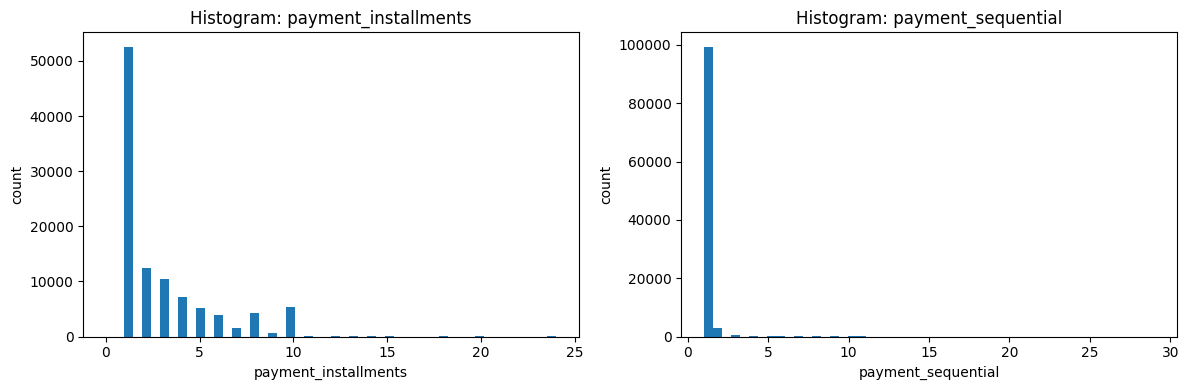

In [121]:
# ---- Two histograms in one figure ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram 1
axes[0].hist(df_payments["payment_installments"], bins=50)
axes[0].set_title("Histogram: payment_installments")
axes[0].set_xlabel("payment_installments")
axes[0].set_ylabel("count")

# Histogram 2
axes[1].hist(df_payments["payment_sequential"], bins=50)
axes[1].set_title("Histogram: payment_sequential")
axes[1].set_xlabel("payment_sequential")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()

In [122]:
df_payments.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

Let's conduct some formal checks

In [123]:
df_payments["payment_sequential"].value_counts().sort_index()

payment_sequential
1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
16        6
17        6
18        6
19        6
20        4
21        4
22        3
23        2
24        2
25        2
26        2
27        1
28        1
29        1
Name: count, dtype: int64

> Clearly, payment_sequential does not require 29 unique values. We can create a binary indicator which tells if an order was paid for with one or more payment methods

In [124]:
df_payments["is_payment_sequential_1"] = (df_payments["payment_sequential"] == 1).astype(int)
df_payments.info()
df_payments.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 103886 non-null  object 
 1   payment_sequential       103886 non-null  int64  
 2   payment_type             103886 non-null  object 
 3   payment_installments     103886 non-null  int64  
 4   payment_value            103886 non-null  float64
 5   is_payment_sequential_1  103886 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value,is_payment_sequential_1
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12,1
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16,1
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84,1
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09,1
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95,1


In [125]:
df_payments.nunique()

order_id                   99440
payment_sequential            29
payment_type                   5
payment_installments          24
payment_value              29077
is_payment_sequential_1        2
dtype: int64

> Now, let's look at payment_type

In [126]:
df_payments["payment_type"].value_counts()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

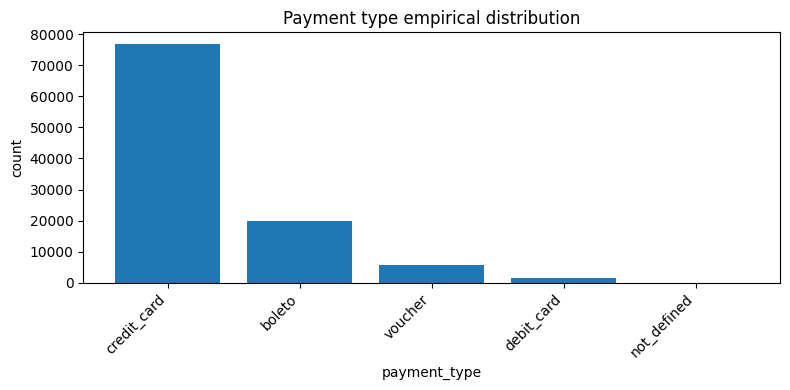

In [127]:
# Count each category
counts = df_payments["payment_type"].value_counts(dropna=False)

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Payment type empirical distribution")
plt.xlabel("payment_type")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


> Let's use one-hot encoding

In [128]:
# One-hot encoded columns (0/1) for payment_type
payment_type_dummies = pd.get_dummies(
    df_payments["payment_type"],
    prefix="payment_type",   # column names 
    dtype=int                # ensures 0/1 integers instead of True/False
)

# Add them to df_payments
df_payments = pd.concat([df_payments, payment_type_dummies], axis=1)
df_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,0,1,0,0,0
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,0,1,0,0,0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,0,1,0,0,0
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,0,1,0,0,0
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,1,1,0,0,0,0
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,1,0,1,0,0,0
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,1,0,1,0,0,0
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,1,0,1,0,0,0


> We should go back to payment_installments and see if we for a unique order_id the value of payment_installments stays the same

In [129]:
# How many unique payment_installments values each order_id has
n_unique_installments = (
    df_payments.groupby("order_id")["payment_installments"]
    .nunique(dropna=False)
)

# Orders where the value is NOT consistent (more than 1 unique value)
bad_orders = n_unique_installments[n_unique_installments > 1]

print(f"Total orders: {n_unique_installments.size}")
print(f"Orders with inconsistent payment_installments: {bad_orders.size}")

# Show a few problematic order_ids
bad_orders.head(10)


Total orders: 99440
Orders with inconsistent payment_installments: 866


order_id
0016dfedd97fc2950e388d2971d718c7    2
00e6bc6b166eb28b4502c1cad4457248    2
02d0cd05f04ab2e3c1acc473b0abc865    2
02ec4da9d03014f06d711d60eb37cc22    2
039f61edec89c6f0edf8dd1a0bdea1fe    2
03a10721769c7d8f2fefab105e64fbef    2
03c968d10d8c63bd2388245d02579fde    2
03ecec245220b63fd7f68c1737ba99ba    2
03f51c9adce893f63936c5146701aa2f    2
0420dbc50fc554e303e4b2d6b39063f6    2
Name: payment_installments, dtype: int64

In [130]:
# View the rows for orders with inconsistent installments
df_payments.loc[df_payments["order_id"].isin(bad_orders.index), 
                ["order_id", "payment_sequential", "payment_type", "payment_installments", "payment_value"] \
               ].sort_values(["order_id", "payment_sequential"])


,order_id,payment_sequential,payment_type,payment_installments,payment_value
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
24134,00e6bc6b166eb28b4502c1cad4457248,1,credit_card,2,85.86
80236,00e6bc6b166eb28b4502c1cad4457248,2,voucher,1,66.07
99441,02d0cd05f04ab2e3c1acc473b0abc865,1,credit_card,3,56.40
...,...,...,...,...,...
86518,fec086a14f64723dead262e2bfba3284,2,voucher,1,100.00
41032,fee9afa24ed743a26803c4d03e8ba5e1,1,credit_card,3,37.89
87715,fee9afa24ed743a26803c4d03e8ba5e1,2,credit_card,2,23.89
44032,ff20ee702706d9e407a34de9fe2ff768,1,credit_card,6,132.10


Clearly, the situation isn't the easiest to deal with. What we can do is create categorical variables *payment_installments_"payment type"* for each payment type, and show for each row the number of installments of a given type.

In [131]:
# One-hot encode payment_type with desired prefix
pt_dummies = pd.get_dummies(
    df_payments["payment_type"],
    prefix="installments",   # -> installments_credit_card, installments_voucher, ...
    dtype=int
)

#  Put the installments value into the matching payment_type column (others become 0)
installments_by_type = pt_dummies.mul(df_payments["payment_installments"].fillna(0), axis=0)

# Add to df_payments
df_payments = pd.concat([df_payments, installments_by_type], axis=1)
df_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_not_defined,installments_voucher
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,0,1,0,0,0,0,8,0,0,0
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,0,1,0,0,0,0,1,0,0,0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,0,1,0,0,0,0,1,0,0,0
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,0,1,0,0,0,0,8,0,0,0
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,0,1,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,1,1,0,0,0,0,1,0,0,0,0
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,1,0,1,0,0,0,0,2,0,0,0
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,1,0,1,0,0,0,0,1,0,0,0
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,1,0,1,0,0,0,0,5,0,0,0


> Now, we are ready to merge the appropriate columns to our main dataframe

In [132]:
cols_to_merge = [
    "order_id",
    "is_payment_sequential_1",
    "payment_type_boleto",
    "payment_type_credit_card",
    "payment_type_debit_card",
    "payment_type_not_defined",
    "payment_type_voucher",
    "installments_boleto",
    "installments_credit_card",
    "installments_debit_card",
    "installments_not_defined",
    "installments_voucher",
]

# Keep just one row per order_id from df_payments 
df_payments_1row = df_payments[cols_to_merge].drop_duplicates(subset=["order_id"]).copy()

# Merge into df_orders_merged2
df_orders_merged2 = df_orders_merged1.merge(
    df_payments_1row,
    on="order_id",
    how="left"
)


In [133]:
df_orders_merged2.info()
df_orders_merged2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93258 entries, 0 to 93257
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93258 non-null  object        
 1   customer_id                    93258 non-null  object        
 2   order_status                   93258 non-null  object        
 3   order_purchase_timestamp       93258 non-null  object        
 4   order_approved_at              93258 non-null  object        
 5   order_delivered_carrier_date   93258 non-null  object        
 6   order_delivered_customer_date  93258 non-null  datetime64[ns]
 7   order_estimated_delivery_date  93258 non-null  datetime64[ns]
 8   delay_days                     93258 non-null  int64         
 9   order_item_id                  93258 non-null  int64         
 10  product_id                     93258 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_not_defined,installments_voucher
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Let's see the nulls

In [134]:
rows_with_nulls = df_orders_merged2[df_orders_merged2.isna().any(axis=1)]
rows_with_nulls

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_not_defined,installments_voucher
28836,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,36,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's just one order - let's delete it and move on

In [135]:
df_orders_merged2 = df_orders_merged2.dropna()
df_orders_merged2

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_not_defined,installments_voucher
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93253,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,-11,1,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
93254,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,-2,1,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
93255,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,-6,1,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
93256,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,-21,2,...,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [136]:
df_orders_merged2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93257 entries, 0 to 93257
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93257 non-null  object        
 1   customer_id                    93257 non-null  object        
 2   order_status                   93257 non-null  object        
 3   order_purchase_timestamp       93257 non-null  object        
 4   order_approved_at              93257 non-null  object        
 5   order_delivered_carrier_date   93257 non-null  object        
 6   order_delivered_customer_date  93257 non-null  datetime64[ns]
 7   order_estimated_delivery_date  93257 non-null  datetime64[ns]
 8   delay_days                     93257 non-null  int64         
 9   order_item_id                  93257 non-null  int64         
 10  product_id                     93257 non-null  object        
 11  seller_id           

## Using product description information

In [137]:
cols_to_merge = [
    "product_id",
    "product_name_lenght",
    "product_description_lenght",
    "product_photos_qty",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
    "product_category_name_english",
]

df_orders_merged3 = df_orders_merged2.merge(
    df_products_nonull[cols_to_merge],
    on="product_id",
    how="left"
)
df_orders_merged3.info()
df_orders_merged3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93257 entries, 0 to 93256
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93257 non-null  object        
 1   customer_id                    93257 non-null  object        
 2   order_status                   93257 non-null  object        
 3   order_purchase_timestamp       93257 non-null  object        
 4   order_approved_at              93257 non-null  object        
 5   order_delivered_carrier_date   93257 non-null  object        
 6   order_delivered_customer_date  93257 non-null  datetime64[ns]
 7   order_estimated_delivery_date  93257 non-null  datetime64[ns]
 8   delay_days                     93257 non-null  int64         
 9   order_item_id                  93257 non-null  int64         
 10  product_id                     93257 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,installments_not_defined,installments_voucher,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,0.0,0.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,0.0,0.0,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,0.0,0.0,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,0.0,0.0,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,0.0,0.0,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery


Let's look at the nulls

In [138]:
rows_with_nulls = df_orders_merged3[df_orders_merged3.isna().any(axis=1)]
rows_with_nulls

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,installments_not_defined,installments_voucher,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
102,bfe42c22ecbf90bc9f35cf591270b6a7,803ac05904124294f8767894d6da532b,delivered,2018-01-27 22:04:34,2018-01-27 22:16:18,2018-02-03 03:56:00,2018-02-09 20:16:40,2018-02-26,-17,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,58ac1947c1a9067b9f416cba6d844a3f,ee8e1d37f563ecc11cc4dcb4dfd794c2,delivered,2017-09-13 09:18:50,2017-09-13 13:45:43,2017-09-14 21:20:03,2017-09-21 21:16:17,2017-09-25,-4,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,e22b71f6e4a481445ec4527cb4c405f7,1faf89c8f142db3fca6cf314c51a37b6,delivered,2017-04-22 13:48:18,2017-04-22 14:01:13,2017-04-24 19:08:53,2017-05-02 15:45:27,2017-05-11,-9,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,a094215e786240fcfefb83d18036a1cd,86acfb656743da0c113d176832c9d535,delivered,2018-02-08 18:56:45,2018-02-08 19:32:18,2018-02-09 21:41:54,2018-02-19 13:28:50,2018-02-22,-3,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,6f841dde94727854eaff3f66432c80ea,a9c9532060c9d245f06526c633d2dfba,delivered,2018-01-02 19:20:35,2018-01-02 19:32:22,2018-01-03 17:34:42,2018-01-27 14:27:59,2018-02-05,-9,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92908,1a10e938a1c7d8e5eecc3380f71ca76b,8a81607347c25d881d995d94de6ad824,delivered,2018-07-25 08:58:35,2018-07-26 03:10:20,2018-07-27 11:32:00,2018-08-01 19:28:20,2018-08-10,-9,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93043,e33865519137f5737444109ae8438633,64b086bdcc54458af3ea3bd838db54a5,delivered,2018-05-28 00:44:06,2018-05-29 03:31:17,2018-05-30 13:13:00,2018-06-01 22:25:39,2018-06-20,-19,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93050,f0dd9af88d8ef5a8e4670fbbedaf19c4,30ddb50bd22ee927ebe308ea3da60735,delivered,2017-09-02 20:38:29,2017-09-05 04:24:12,2017-09-14 23:13:41,2017-09-15 14:59:50,2017-09-19,-4,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93056,272874573723eec18f23c0471927d778,48e080c8001e92ebea2b64e474f91a60,delivered,2017-12-20 23:10:33,2017-12-20 23:29:37,2017-12-21 21:49:35,2017-12-26 22:29:32,2018-01-09,-14,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We seem to lack information about certain product_ids. Let's remove these nulls and procede

In [139]:
df_orders_merged3 = df_orders_merged3.dropna().reset_index(drop=True)
df_orders_merged3.info()
df_orders_merged3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,installments_not_defined,installments_voucher,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,0.0,0.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,0.0,0.0,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,0.0,0.0,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,0.0,0.0,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,0.0,0.0,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery


In [140]:
df_orders_merged3.nunique()

order_id                         91932
customer_id                      91932
order_status                         1
order_purchase_timestamp         91466
order_approved_at                84374
order_delivered_carrier_date     76572
order_delivered_customer_date    91198
order_estimated_delivery_date      444
delay_days                         195
order_item_id                       16
product_id                       29680
seller_id                         2884
n_distinct_sellers                   1
n_distinct_products                  1
total_price                       6576
total_freight                     7146
order_value_check                28753
is_payment_sequential_1              2
payment_type_boleto                  2
payment_type_credit_card             2
payment_type_debit_card              2
payment_type_not_defined             1
payment_type_voucher                 2
installments_boleto                  2
installments_credit_card            24
installments_debit_card  

> An important note for later: for our models, we will need to encode *product_category_name_english* in a specific way. This way, however, will depend on the model used, so for now we just use a simple numerical transformation and create a separate column.

In [141]:
df_orders_merged3["product_category_name_english"] = df_orders_merged3["product_category_name_english"].astype("category")
df_orders_merged3.info()
df_orders_merged3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,installments_not_defined,installments_voucher,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,0.0,0.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,0.0,0.0,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,0.0,0.0,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,0.0,0.0,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,0.0,0.0,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery


In [142]:
cat = df_orders_merged3["product_category_name_english"].astype("category")

mapping = (
    cat.cat.categories
      .to_series()
      .reset_index(drop=True)
      .reset_index()
)
mapping.columns = ["code", "category_name"]
mapping


,code,category_name
0,0,agro_industry_and_commerce
1,1,air_conditioning
2,2,art
3,3,arts_and_craftmanship
4,4,audio
...,...,...
68,68,stationery
69,69,tablets_printing_image
70,70,telephony
71,71,toys


We can see the encoding by pandas

## Using sellers information

In [143]:
df_orders_merged4 = df_orders_merged3.merge(
    df_sellers[["seller_id", "seller_state"]],
    on="seller_id",
    how="left"
)
df_orders_merged4.info()
df_orders_merged4.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,installments_voucher,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,0.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,0.0,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,0.0,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,0.0,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,0.0,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery,SP


Everything seems in order

## Using customers information

In [144]:
df_orders_merged5 = df_orders_merged4.merge(
    df_customers[["customer_id", "customer_state"]],
    on="customer_id",
    how="left"
)
df_orders_merged5.info()
df_orders_merged5.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,SP,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,SP,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,SP,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop,MG,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery,SP,SP


Everything seems fine. **An interesting piece of information may be to construct a binary variable to indicate if customer and seller states are the same for a given order. This would give us some measure of closeness.**

In [145]:
df_orders_merged5["cust_sell_same_state"] = (
    df_orders_merged5["customer_state"] == df_orders_merged5["seller_state"]
).astype(int)
df_orders_merged5.info()
df_orders_merged5.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,SP,SP,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,SP,BA,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,232.0,1.0,420.0,24.0,19.0,21.0,auto,SP,GO,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop,MG,RN,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,316.0,4.0,250.0,51.0,15.0,15.0,stationery,SP,SP,1


In [146]:
df_orders_merged5["cust_sell_same_state"].value_counts()

cust_sell_same_state
0    58941
1    32991
Name: count, dtype: int64

Interesting, it seems like we have around one third of the orders being ordered and delivered in the same state. The rest is cross-state

## Using geolocation information

> We can design a distance metric which will show us the distance between customer and seller. In order to do that, we need to introduce *zip_code_prefix* from *df_customer* and *df_seller*. Then, we can use the mapping (based on zip_code_prefix) from *df_geolocation* in order to extract appropriate information about longitude and latitude.

In [147]:
# Add seller_zip_code_prefix (merge on seller_id) ----
df_orders_merged6 = df_orders_merged5.merge(
    df_sellers[["seller_id", "seller_zip_code_prefix"]],
    on="seller_id",
    how="left"
)

# Add customer_zip_code_prefix (merge on customer_id) ----
df_orders_merged7 = df_orders_merged6.merge(
    df_customers[["customer_id", "customer_zip_code_prefix"]],
    on="customer_id",
    how="left"
)

df_orders_merged7.info()
df_orders_merged7.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state,seller_zip_code_prefix,customer_zip_code_prefix
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,500.0,19.0,8.0,13.0,housewares,SP,SP,1,9350,3149
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,400.0,19.0,13.0,19.0,perfumery,SP,BA,0,31570,47813
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,420.0,24.0,19.0,21.0,auto,SP,GO,0,14840,75265
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,450.0,30.0,10.0,20.0,pet_shop,MG,RN,0,31842,59296
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,250.0,51.0,15.0,15.0,stationery,SP,SP,1,8752,9195


In [148]:
# Build a 1-row-per-zip-prefix lookup from df_geolocation
geo_zip = (
    df_geolocation[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]] # just the three variables of interest
    .drop_duplicates(subset=["geolocation_zip_code_prefix"])
)

# Customer: match customer_zip_code_prefix -> customer_lat/lng
df_orders_merged8 = df_orders_merged7.merge(
    geo_zip.rename(columns={
        "geolocation_zip_code_prefix": "customer_zip_code_prefix",
        "geolocation_lat": "customer_lat",
        "geolocation_lng": "customer_lng",
    }),
    on="customer_zip_code_prefix",
    how="left"
)

# Seller: match seller_zip_code_prefix -> seller_lat/lng
df_orders_merged9 = df_orders_merged8.merge(
    geo_zip.rename(columns={
        "geolocation_zip_code_prefix": "seller_zip_code_prefix",
        "geolocation_lat": "seller_lat",
        "geolocation_lng": "seller_lng",
    }),
    on="seller_zip_code_prefix",
    how="left"
)

df_orders_merged9.info()
df_orders_merged9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,product_category_name_english,seller_state,customer_state,cust_sell_same_state,seller_zip_code_prefix,customer_zip_code_prefix,customer_lat,customer_lng,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,housewares,SP,SP,1,9350,3149,-23.574809,-46.587471,-23.680114,-46.452454
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,perfumery,SP,BA,0,31570,47813,-12.169860,-44.988369,-19.810119,-43.984727
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,auto,SP,GO,0,14840,75265,-16.746337,-48.514624,-21.362358,-48.232976
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,pet_shop,MG,RN,0,31842,59296,-5.767733,-35.275467,-19.840168,-43.923299
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,stationery,SP,SP,1,8752,9195,-23.675037,-46.524784,-23.551707,-46.260979


Now, using [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) we can compute the distance in *km* between seller and customer.

In [149]:
R = 6371.0  # Earth radius in km

lat1 = np.radians(df_orders_merged9["customer_lat"].astype(float))
lon1 = np.radians(df_orders_merged9["customer_lng"].astype(float))
lat2 = np.radians(df_orders_merged9["seller_lat"].astype(float))
lon2 = np.radians(df_orders_merged9["seller_lng"].astype(float))

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) # using arctan may be numerically more stable

df_orders_merged9["cust_sell_distance_km"] = R * c

df_orders_merged9.info()
df_orders_merged9.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91932 entries, 0 to 91931
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       91932 non-null  object        
 1   customer_id                    91932 non-null  object        
 2   order_status                   91932 non-null  object        
 3   order_purchase_timestamp       91932 non-null  object        
 4   order_approved_at              91932 non-null  object        
 5   order_delivered_carrier_date   91932 non-null  object        
 6   order_delivered_customer_date  91932 non-null  datetime64[ns]
 7   order_estimated_delivery_date  91932 non-null  datetime64[ns]
 8   delay_days                     91932 non-null  int64         
 9   order_item_id                  91932 non-null  int64         
 10  product_id                     91932 non-null  object        
 11  seller_id      

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,order_item_id,...,seller_state,customer_state,cust_sell_same_state,seller_zip_code_prefix,customer_zip_code_prefix,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,1,...,SP,SP,1,9350,3149,-23.574809,-46.587471,-23.680114,-46.452454,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,1,...,SP,BA,0,31570,47813,-12.169860,-44.988369,-19.810119,-43.984727,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,1,...,SP,GO,0,14840,75265,-16.746337,-48.514624,-21.362358,-48.232976,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,1,...,MG,RN,0,31842,59296,-5.767733,-35.275467,-19.840168,-43.923299,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,1,...,SP,SP,1,8752,9195,-23.675037,-46.524784,-23.551707,-46.260979,30.174037


> **Wherever there is a null in lat/lng for customer or seller, we get a null in the distance as well. Let's run a quick sanity check to see if any distances are negative:**

In [150]:
# Sanity checks for cust_sell_distance
dist = df_orders_merged9["cust_sell_distance_km"]

# 1) How many are negative? (ignore NaNs)
n_negative = (dist.dropna() < 0).sum()
print("Negative distances:", n_negative)

Negative distances: 0


> Great! Everything seems to be in order. Finally, let's drop the null values.

In [151]:
df_orders_merged9 = df_orders_merged9.dropna().reset_index()
df_orders_merged9.info()
df_orders_merged9.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  object        
 5   order_approved_at              91475 non-null  object        
 6   order_delivered_carrier_date   91475 non-null  object        
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,...,seller_state,customer_state,cust_sell_same_state,seller_zip_code_prefix,customer_zip_code_prefix,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,...,SP,SP,1,9350,3149,-23.574809,-46.587471,-23.680114,-46.452454,18.063837
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,...,SP,BA,0,31570,47813,-12.169860,-44.988369,-19.810119,-43.984727,856.292580
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,...,SP,GO,0,14840,75265,-16.746337,-48.514624,-21.362358,-48.232976,514.130333
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,...,MG,RN,0,31842,59296,-5.767733,-35.275467,-19.840168,-43.923299,1822.800366
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,...,SP,SP,1,8752,9195,-23.675037,-46.524784,-23.551707,-46.260979,30.174037


## Final touches

There isn't anything more we can add from the remaining dataframes. Now, we will create some variables of interest based on our *df_orders_merged9*. However, before we do that let's present a short summary of how we have used the different databases to construct our merged dataset.

> **The base dataframe is the df_orders as it contains the information necessary to creat the order delay variable**

We decided to include only orders with one product type/seller to allow for appropriate feature mapping. The rationale is described in previous sections of this notebook.

We took advantage of variables such as *order_id, geolocation_zip_code_prefix, customer_id, product_id, and seller_id* to adequately map information between dataframes to appropriate orders:

* **df_customers** (map - customer_id): customer state
* **df_geolocation** (map - geolocation_zip_code_prefix): geolocation_lat, geolocation_lng as location for customers and sellers
* **df_order_items** (map - order_id, product_id, seller_id): number of products in order, total price and freight value (sums to order value)
* **df_payments** (map - order_id): types of payments, if a payment is sequential, number of installments by different payment types
* **df_products** (map - product_id): product category, dimensions, and website description information
* **df_sellers** (map - seller_id): seller location information
* **df_prod_translate** (map - product_id): product category translation

In [152]:
df_orders_merged9.info()
df_orders_merged9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  object        
 5   order_approved_at              91475 non-null  object        
 6   order_delivered_carrier_date   91475 non-null  object        
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,...,seller_state,customer_state,cust_sell_same_state,seller_zip_code_prefix,customer_zip_code_prefix,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,...,SP,SP,1,9350,3149,-23.574809,-46.587471,-23.680114,-46.452454,18.063837
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,...,SP,BA,0,31570,47813,-12.169860,-44.988369,-19.810119,-43.984727,856.292580
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,...,SP,GO,0,14840,75265,-16.746337,-48.514624,-21.362358,-48.232976,514.130333
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,...,MG,RN,0,31842,59296,-5.767733,-35.275467,-19.840168,-43.923299,1822.800366
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,...,SP,SP,1,8752,9195,-23.675037,-46.524784,-23.551707,-46.260979,30.174037


In [153]:
df_orders_merged9.nunique()

index                            91475
order_id                         91475
customer_id                      91475
order_status                         1
order_purchase_timestamp         91013
order_approved_at                83977
order_delivered_carrier_date     76212
order_delivered_customer_date    90747
order_estimated_delivery_date      444
delay_days                         195
order_item_id                       16
product_id                       29583
seller_id                         2877
n_distinct_sellers                   1
n_distinct_products                  1
total_price                       6557
total_freight                     7135
order_value_check                28668
is_payment_sequential_1              2
payment_type_boleto                  2
payment_type_credit_card             2
payment_type_debit_card              2
payment_type_not_defined             1
payment_type_voucher                 2
installments_boleto                  2
installments_credit_card 

### Some other variables of interest

> While we are treating our data as a pooled cross-section, it may be beneficial to include month and year indicators into our data

Some clean-up

In [154]:
df_orders_merged9["order_purchase_timestamp"] = pd.to_datetime(df_orders_merged9["order_purchase_timestamp"])
df_orders_merged9["order_approved_at"] = pd.to_datetime(df_orders_merged9["order_approved_at"])
df_orders_merged9["order_delivered_carrier_date"] = pd.to_datetime(df_orders_merged9["order_delivered_carrier_date"])
df_orders_merged9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  datetime64[ns]
 5   order_approved_at              91475 non-null  datetime64[ns]
 6   order_delivered_carrier_date   91475 non-null  datetime64[ns]
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

In [155]:
# Month of ordering (1–12) and month of delivery (1–12)
df_orders_merged9["order_purchase_month"] = df_orders_merged9["order_purchase_timestamp"].dt.month.astype("Int64")
df_orders_merged9["order_delivery_month"] = df_orders_merged9["order_delivered_customer_date"].dt.month.astype("Int64")

# Make them categorical (keeps NaNs if delivery date is missing)
df_orders_merged9["order_purchase_month"] = df_orders_merged9["order_purchase_month"].astype("category")
df_orders_merged9["order_delivery_month"] = df_orders_merged9["order_delivery_month"].astype("category")

df_orders_merged9.info()
df_orders_merged9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  datetime64[ns]
 5   order_approved_at              91475 non-null  datetime64[ns]
 6   order_delivered_carrier_date   91475 non-null  datetime64[ns]
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,...,cust_sell_same_state,seller_zip_code_prefix,customer_zip_code_prefix,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,...,1,9350,3149,-23.574809,-46.587471,-23.680114,-46.452454,18.063837,10,10
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,...,0,31570,47813,-12.169860,-44.988369,-19.810119,-43.984727,856.292580,7,8
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,...,0,14840,75265,-16.746337,-48.514624,-21.362358,-48.232976,514.130333,8,8
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,...,0,31842,59296,-5.767733,-35.275467,-19.840168,-43.923299,1822.800366,11,12
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,...,1,8752,9195,-23.675037,-46.524784,-23.551707,-46.260979,30.174037,2,2


In [156]:
# Extract years
df_orders_merged9["order_purchase_year"] = df_orders_merged9["order_purchase_timestamp"].dt.year.astype("Int64")
df_orders_merged9["order_delivery_year"] = df_orders_merged9["order_delivered_customer_date"].dt.year.astype("Int64")

# Create dummy variables (one-hot)
purchase_year_dummies = pd.get_dummies(
    df_orders_merged9["order_purchase_year"],
    prefix="order_year",
    dtype=int
)

delivery_year_dummies = pd.get_dummies(
    df_orders_merged9["order_delivery_year"],
    prefix="delivery_year",
    dtype=int
)

# Add them to df_orders_merged9
df_orders_merged9 = pd.concat(
    [df_orders_merged9, purchase_year_dummies, delivery_year_dummies],
    axis=1
)

df_orders_merged9.info()
df_orders_merged9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  datetime64[ns]
 5   order_approved_at              91475 non-null  datetime64[ns]
 6   order_delivered_carrier_date   91475 non-null  datetime64[ns]
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,...,order_purchase_month,order_delivery_month,order_purchase_year,order_delivery_year,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,...,10,10,2017,2017,0,1,0,0,1,0
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,...,7,8,2018,2018,0,0,1,0,0,1
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,...,8,8,2018,2018,0,0,1,0,0,1
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,...,11,12,2017,2017,0,1,0,0,1,0
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,...,2,2,2018,2018,0,0,1,0,0,1


These variables were used to ensure we do not skip any years included. Let's delete them:

In [157]:
df_orders_merged9 = df_orders_merged9.drop(columns=["order_purchase_year", "order_delivery_year"])

df_orders_merged9.info()
df_orders_merged9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  datetime64[ns]
 5   order_approved_at              91475 non-null  datetime64[ns]
 6   order_delivered_carrier_date   91475 non-null  datetime64[ns]
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,...,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,...,-46.452454,18.063837,10,10,0,1,0,0,1,0
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,...,-43.984727,856.292580,7,8,0,0,1,0,0,1
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,...,-48.232976,514.130333,8,8,0,0,1,0,0,1
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,...,-43.923299,1822.800366,11,12,0,1,0,0,1,0
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,...,-46.260979,30.174037,2,2,0,0,1,0,0,1


Let's also recode seller and customer state as categories

In [158]:
df_orders_merged9["seller_state"] = df_orders_merged9["seller_state"].astype("category")
df_orders_merged9["customer_state"] = df_orders_merged9["customer_state"].astype("category")

df_orders_merged9.info()
df_orders_merged9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  datetime64[ns]
 5   order_approved_at              91475 non-null  datetime64[ns]
 6   order_delivered_carrier_date   91475 non-null  datetime64[ns]
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,...,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,...,-46.452454,18.063837,10,10,0,1,0,0,1,0
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,...,-43.984727,856.292580,7,8,0,0,1,0,0,1
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,...,-48.232976,514.130333,8,8,0,0,1,0,0,1
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,...,-43.923299,1822.800366,11,12,0,1,0,0,1,0
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,...,-46.260979,30.174037,2,2,0,0,1,0,0,1


We may also add day of the week for purchase, estimate and actual delivery to see if it could in any way affect delays

In [172]:
# 0 = Monday, 6 = Sunday
df_orders_merged9["order_purchase_dow"] = df_orders_merged9["order_purchase_timestamp"].dt.dayofweek.astype("int64")
df_orders_merged9["order_estimate_dow"] = df_orders_merged9["order_estimated_delivery_date"].dt.dayofweek.astype("int64")
df_orders_merged9["order_delivery_dow"] = df_orders_merged9["order_delivered_customer_date"].dt.dayofweek.astype("int64")

df_orders_merged9.info()
df_orders_merged9.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          91475 non-null  int64         
 1   order_id                       91475 non-null  object        
 2   customer_id                    91475 non-null  object        
 3   order_status                   91475 non-null  object        
 4   order_purchase_timestamp       91475 non-null  datetime64[ns]
 5   order_approved_at              91475 non-null  datetime64[ns]
 6   order_delivered_carrier_date   91475 non-null  datetime64[ns]
 7   order_delivered_customer_date  91475 non-null  datetime64[ns]
 8   order_estimated_delivery_date  91475 non-null  datetime64[ns]
 9   delay_days                     91475 non-null  int64         
 10  order_item_id                  91475 non-null  int64         
 11  product_id     

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_days,...,order_delivery_month,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,...,10,0,1,0,0,1,0,0,1,2
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,...,8,0,0,1,0,0,1,1,1,0
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,...,8,0,0,1,0,0,1,2,4,1
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,...,12,0,1,0,0,1,0,5,5,4
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,...,2,0,0,1,0,0,1,1,4,0


# Saving dataset files

> **At this point we can basically save our dataframe as a csv file for further use.**

> In order to make it easier for us to navigate this dataset for the purposes of modelling, **we will remove the "id" columns whose sole purpose was appropriate mapping of features; they are not features themselves. We will also remove the reduntant columns not usable by our models (like the datetime variables)**

> **As a precaution we will still save a version of the file with the "ids" in case we need to go back to them**

In [173]:
df_orders_merged9.to_csv("2.processed_data/preprocessed_dataset_with_indices.csv", index=False)

A new dataframe for modeling

In [174]:
df_orders_merged_final_wo_indices = df_orders_merged9.drop(
    columns = [ "index", "order_id", "customer_id", 
                "product_id", "seller_id", # ids
                "order_purchase_timestamp",	"order_approved_at", "order_status",
            	"order_delivered_carrier_date",	"order_delivered_customer_date",	"order_estimated_delivery_date", # order-related dates
                "seller_zip_code_prefix","customer_zip_code_prefix"

])

df_orders_merged_final_wo_indices.info()
df_orders_merged_final_wo_indices.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  int64   
 1   order_item_id                  91475 non-null  int64   
 2   n_distinct_sellers             91475 non-null  int64   
 3   n_distinct_products            91475 non-null  int64   
 4   total_price                    91475 non-null  float64 
 5   total_freight                  91475 non-null  float64 
 6   order_value_check              91475 non-null  float64 
 7   is_payment_sequential_1        91475 non-null  float64 
 8   payment_type_boleto            91475 non-null  float64 
 9   payment_type_credit_card       91475 non-null  float64 
 10  payment_type_debit_card        91475 non-null  float64 
 11  payment_type_not_defined       91475 non-null  float64 
 12  payment_type_voucher           9

,delay_days,order_item_id,n_distinct_sellers,n_distinct_products,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,...,order_delivery_month,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-8,1,1,1,29.99,8.72,38.71,1.0,0.0,1.0,...,10,0,1,0,0,1,0,0,1,2
1,-6,1,1,1,118.70,22.76,141.46,1.0,1.0,0.0,...,8,0,0,1,0,0,1,1,1,0
2,-18,1,1,1,159.90,19.22,179.12,1.0,0.0,1.0,...,8,0,0,1,0,0,1,2,4,1
3,-13,1,1,1,45.00,27.20,72.20,1.0,0.0,1.0,...,12,0,1,0,0,1,0,5,5,4
4,-10,1,1,1,19.90,8.72,28.62,1.0,0.0,1.0,...,2,0,0,1,0,0,1,1,4,0


In [175]:
df_orders_merged_final_wo_indices.nunique()

delay_days                         195
order_item_id                       16
n_distinct_sellers                   1
n_distinct_products                  1
total_price                       6557
total_freight                     7135
order_value_check                28668
is_payment_sequential_1              2
payment_type_boleto                  2
payment_type_credit_card             2
payment_type_debit_card              2
payment_type_not_defined             1
payment_type_voucher                 2
installments_boleto                  2
installments_credit_card            24
installments_debit_card              2
installments_not_defined             1
installments_voucher                 2
product_name_lenght                 64
product_description_lenght        2929
product_photos_qty                  19
product_weight_g                  2139
product_length_cm                   99
product_height_cm                  101
product_width_cm                    94
product_category_name_eng

In [176]:
df_orders_merged_final_wo_indices["installments_not_defined"].value_counts()

installments_not_defined
0.0    91475
Name: count, dtype: int64

In [177]:
df_orders_merged_final_wo_indices["payment_type_not_defined"].value_counts()

payment_type_not_defined
0.0    91475
Name: count, dtype: int64

In [178]:
df_orders_merged_final_wo_indices["n_distinct_sellers"].value_counts()

n_distinct_sellers
1    91475
Name: count, dtype: int64

In [179]:
df_orders_merged_final_wo_indices["n_distinct_products"].value_counts()

n_distinct_products
1    91475
Name: count, dtype: int64

> **It seems we have failed to notice that given our rule for choosing orders, columns n_distinct_sellers and n_distinct_products are redundant.**

> Installments not defined  and payment not defined also only has one value

> Let's also change delay_days into a float

In [180]:
df_orders_merged_final_wo_indices = df_orders_merged_final_wo_indices.drop(
    columns = ["n_distinct_sellers", "n_distinct_products", "installments_not_defined", "payment_type_not_defined"])

df_orders_merged_final_wo_indices["delay_days"] = df_orders_merged_final_wo_indices["delay_days"].astype(float)

df_orders_merged_final_wo_indices.info()
df_orders_merged_final_wo_indices.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   delay_days                     91475 non-null  float64 
 1   order_item_id                  91475 non-null  int64   
 2   total_price                    91475 non-null  float64 
 3   total_freight                  91475 non-null  float64 
 4   order_value_check              91475 non-null  float64 
 5   is_payment_sequential_1        91475 non-null  float64 
 6   payment_type_boleto            91475 non-null  float64 
 7   payment_type_credit_card       91475 non-null  float64 
 8   payment_type_debit_card        91475 non-null  float64 
 9   payment_type_voucher           91475 non-null  float64 
 10  installments_boleto            91475 non-null  float64 
 11  installments_credit_card       91475 non-null  float64 
 12  installments_debit_card        9

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,...,order_delivery_month,order_year_2016,order_year_2017,order_year_2018,delivery_year_2016,delivery_year_2017,delivery_year_2018,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-8.0,1,29.99,8.72,38.71,1.0,0.0,1.0,0.0,0.0,...,10,0,1,0,0,1,0,0,1,2
1,-6.0,1,118.70,22.76,141.46,1.0,1.0,0.0,0.0,0.0,...,8,0,0,1,0,0,1,1,1,0
2,-18.0,1,159.90,19.22,179.12,1.0,0.0,1.0,0.0,0.0,...,8,0,0,1,0,0,1,2,4,1
3,-13.0,1,45.00,27.20,72.20,1.0,0.0,1.0,0.0,0.0,...,12,0,1,0,0,1,0,5,5,4
4,-10.0,1,19.90,8.72,28.62,1.0,0.0,1.0,0.0,0.0,...,2,0,0,1,0,0,1,1,4,0


In [181]:
df_orders_merged_final_wo_indices.nunique()

delay_days                         195
order_item_id                       16
total_price                       6557
total_freight                     7135
order_value_check                28668
is_payment_sequential_1              2
payment_type_boleto                  2
payment_type_credit_card             2
payment_type_debit_card              2
payment_type_voucher                 2
installments_boleto                  2
installments_credit_card            24
installments_debit_card              2
installments_voucher                 2
product_name_lenght                 64
product_description_lenght        2929
product_photos_qty                  19
product_weight_g                  2139
product_length_cm                   99
product_height_cm                  101
product_width_cm                    94
product_category_name_english       73
seller_state                        22
customer_state                      27
cust_sell_same_state                 2
customer_lat             

> **Now, we can save**

In [182]:
df_orders_merged_final_wo_indices.to_csv("2.processed_data/preprocessed_dataset_for_models.csv", index=False)

> **In the next notebook, we try to rank our features and assess their usefulness**